### Table of contents
1. [Supp Figure 6A-B. Cox models for PFS in TKI arm of IMM151 and JAV101 (IFNG signatures)](#1)
2. [Supp Figure 6C-D. Logistic regression models for CB vs NCB in IO+VEGF arm of IMM151 and JAV101 (IFNG signatures)](#2)
3. [Supp Figure 6E-F. Logistic regression models for CB vs NCB in TKI arm of IMM151 and JAV101 (IFNG signatures)](#3)
4. [Supp Figure 6G-J. Cox models for PFS in IO+VEGF arm of IMM151 and JAV101 (Krishna_CD8A_Tissue_resident-high samples, stratified myeloid IFNG signaling)](#4)
5. [Supp Figure 6K-N. Overfitting analysis. Cox models for PFS in IO+VEGF arm of IMM151 and JAV101 (Krishna_CD8A_Tissue_resident-high samples, stratified myeloid IFNG signaling, translating cutoffs between cohorts)](#5)

In [4]:
library(harmony)
library(hacksig)
library(car)
library(corrplot)
library(ComplexHeatmap)
library(rstatix)
library(stringr)
library(Seurat)
library(useful)
library(dplyr)
library(ggpubr)
library(ggrepel)
library(glue)
library(RColorBrewer)
library(ggpubr)
library(ggrepel)
library(reshape2)
library(lmerTest)
library(Scillus)
library(cowplot)
library(viridis)
library(hrbrthemes)
library(ggridges)
library(pheatmap)
library(ggplot2)
library(magrittr)
library(broom)
library(yarrr)

library(survival)
library(survminer)
library(tidyverse)
library(forestmodel)
library(scales)
library(pROC)
library(car)


set.seed(1234)

options(repr.plot.width=12, repr.plot.height=9)

### Create figure output directory

In [2]:
dir.create("../../Supp_Figures_Final/Figure_S6")

### Read in CTS ISG signatures

In [3]:
ISG_sigs = readRDS("../../Signatures/Final_Manuscript_Signatures_CTS_ISGs.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

[1] "IFI30"    "LPAR6"    "FCGR1A"   "MYD88"    "VSIG4"    "LILRB1"  
 [7] "IL10"     "SECTM1"   "MX2"      "CXCL10"   "CD86"     "GCH1"    
[13] "SIGLEC10" "FPR1"     "JAK2"     "CXCL9"    "TNFAIP2"  "PTGS2"   
[19] "IL15"     "LAMP3"    "NFKB1"

[1] "C1R"     "PFKP"    "TNFAIP6" "C1S"     "CFB"     "SSPN"

[1] "NLRC5" "OASL"  "IL2RB" "XCL1"  "GZMA"  "STAT4" "CCL5"  "SOCS1"

### Supp Figure 6A-B. Cox models for PFS in TKI arm of IMM151 and JAV101 (IFNG signatures) <a name="1"></a>

### Set panels for forest_model plots

In [5]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Hazard ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### IMM151

In [6]:
clin_imm151_full = readRDS("../../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

df = data.frame(table(colnames(clin_imm151_full)))
subset(df, Freq > 1)

clin_imm151_full = subset(clin_imm151_full, select = -c(IFIT3) )

Var1  Freq
8604 IFIT3 2


 CB NCB 
255 123 

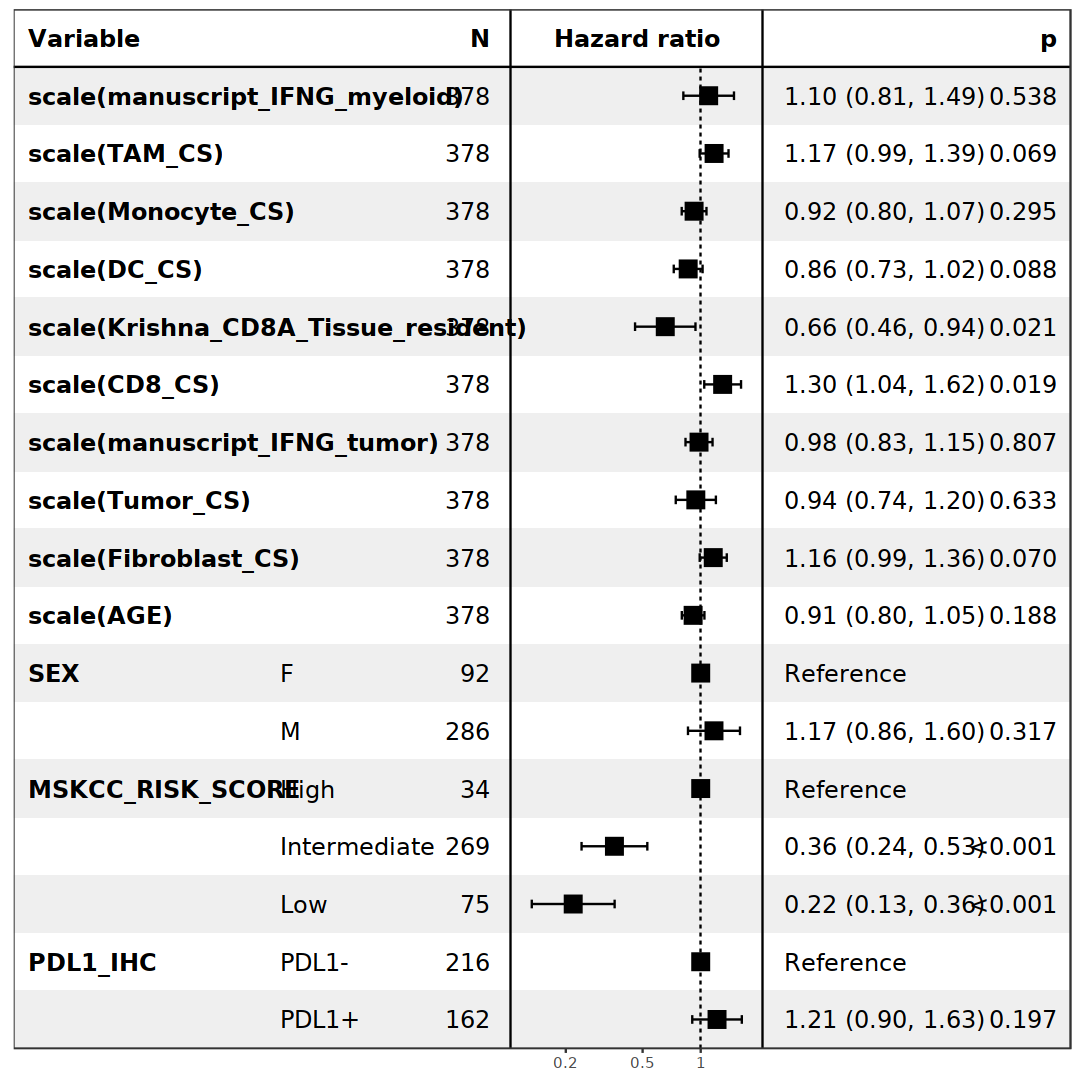

In [7]:
options(repr.plot.width=9, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS)+ scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib)
imm151_plot = forest_model(res.cox, panels,recalculate_width = F)
imm151_plot

### JAV101

In [8]:
clin_jav101_full = readRDS("../../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

df = data.frame(table(colnames(clin_jav101_full)))
subset(df, Freq > 1)

clin_jav101_full = subset(clin_jav101_full, select = -c(CD8A,Eosinophils,IFIT3, Neutrophils) )

Var1        Freq
14682 CD8A        2   
17979 Eosinophils 2   
21236 IFIT3       2   
27495 Neutrophils 2


 CB NCB 
182 161 

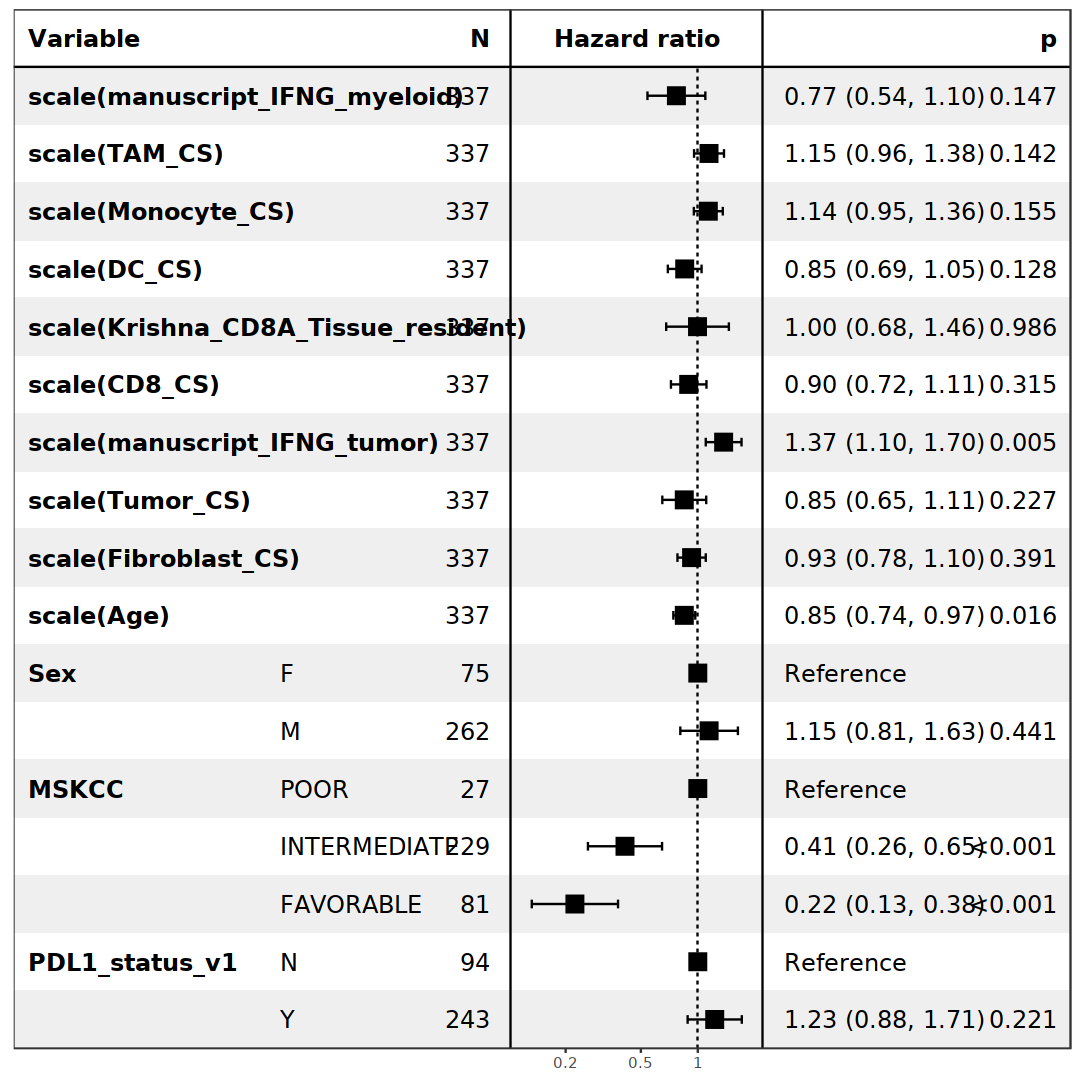

In [9]:
options(repr.plot.width=9, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib)
jav101_plot = forest_model(res.cox, panels,recalculate_width = F)
jav101_plot

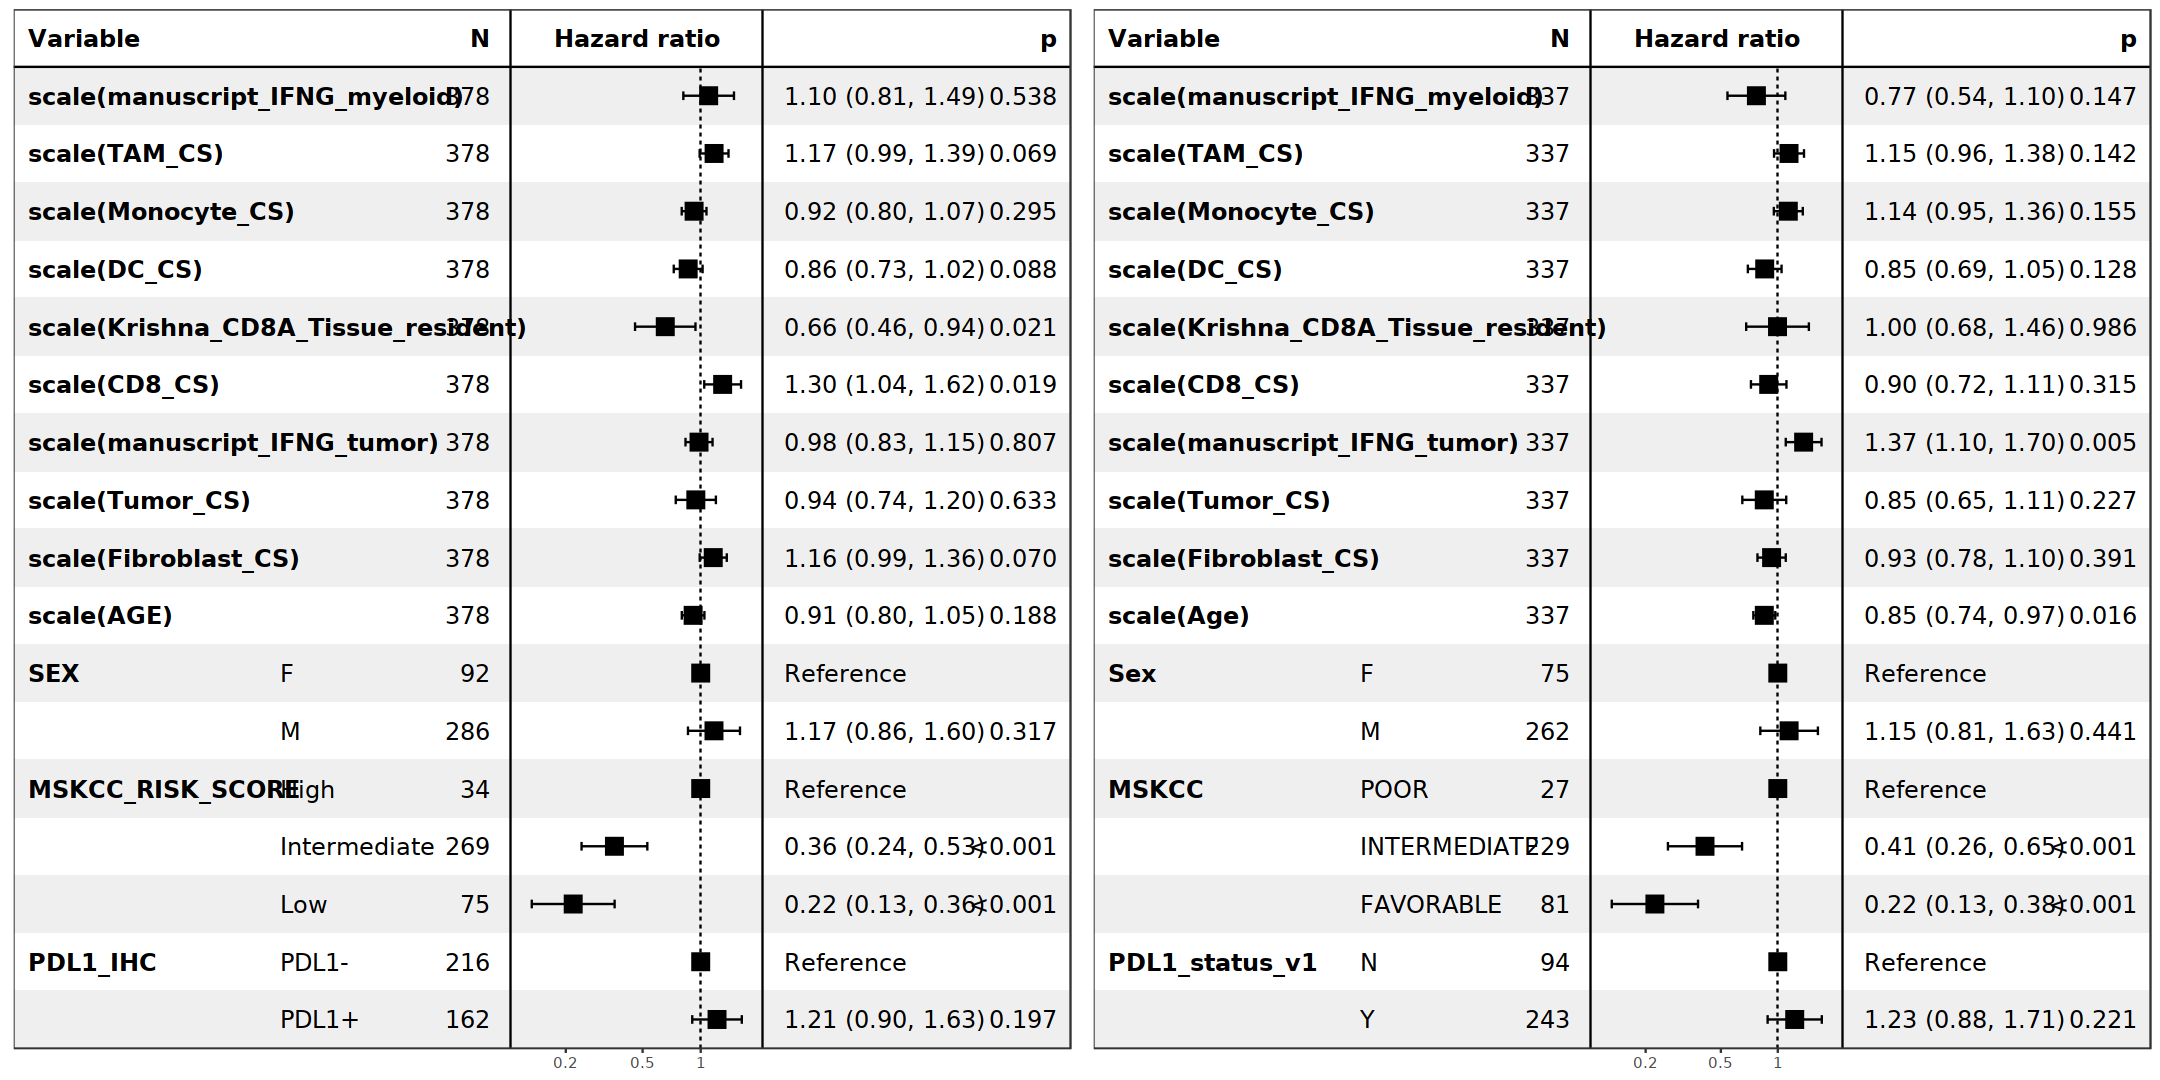

In [10]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(imm151_plot, jav101_plot)

ggsave("../../Supp_Figures_Final/Figure_S6/FigureS6A_B_Cox_IMM151_JAV101_TKI_Scaled.pdf",width = 18, height = 9)

### Supp Figure 6C-D. Logistic regression models for CB vs NCB in IO+VEGF arm of IMM151 and JAV101 (IFNG signatures) <a name="2"></a>

In [11]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Odds ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### IMM151


 CB NCB 
263 117 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + 
    PDL1_IHC, family = "binomial", data = atezo_bev)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2325  -1.1404   0.6472   0.8710   1.6772  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)  
(Intercept)                          0.69135    0.40248   1.718   0.0858 .
scale(manuscript_IFNG_myeloid)      -0.57556    0.24457  -2.353   0.0186 *
scale(TAM_CS)                       -0.18354    0.15939  -1.152   0.2495  
scale(Monocyte_CS)                   0.07020    0.15436   0.455   0.6492  
scale(DC_CS)                         0.02477    0.15278   0.162   0.8712  
scale(Krishna_CD8A_Tissue_resident)  0.67831    0.30746   2.2

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      4.445117 1  2.108345       
scale(TAM_CS)                       1.902452 1  1.379294       
scale(Monocyte_CS)                  1.778382 1  1.333560       
scale(DC_CS)                        1.311711 1  1.145299       
scale(Krishna_CD8A_Tissue_resident) 7.044035 1  2.654060       
scale(CD8_CS)                       2.592113 1  1.610004       
scale(manuscript_IFNG_tumor)        1.738804 1  1.318637       
scale(Tumor_CS)                     4.863467 1  2.205327       
scale(Fibroblast_CS)                1.966291 1  1.402245       
scale(AGE)                          1.150244 1  1.072494       
SEX                                 1.108564 1  1.052884       
MSKCC_RISK_SCORE                    1.129638 2  1.030943       
PDL1_IHC                            1.330956 1  1.153671

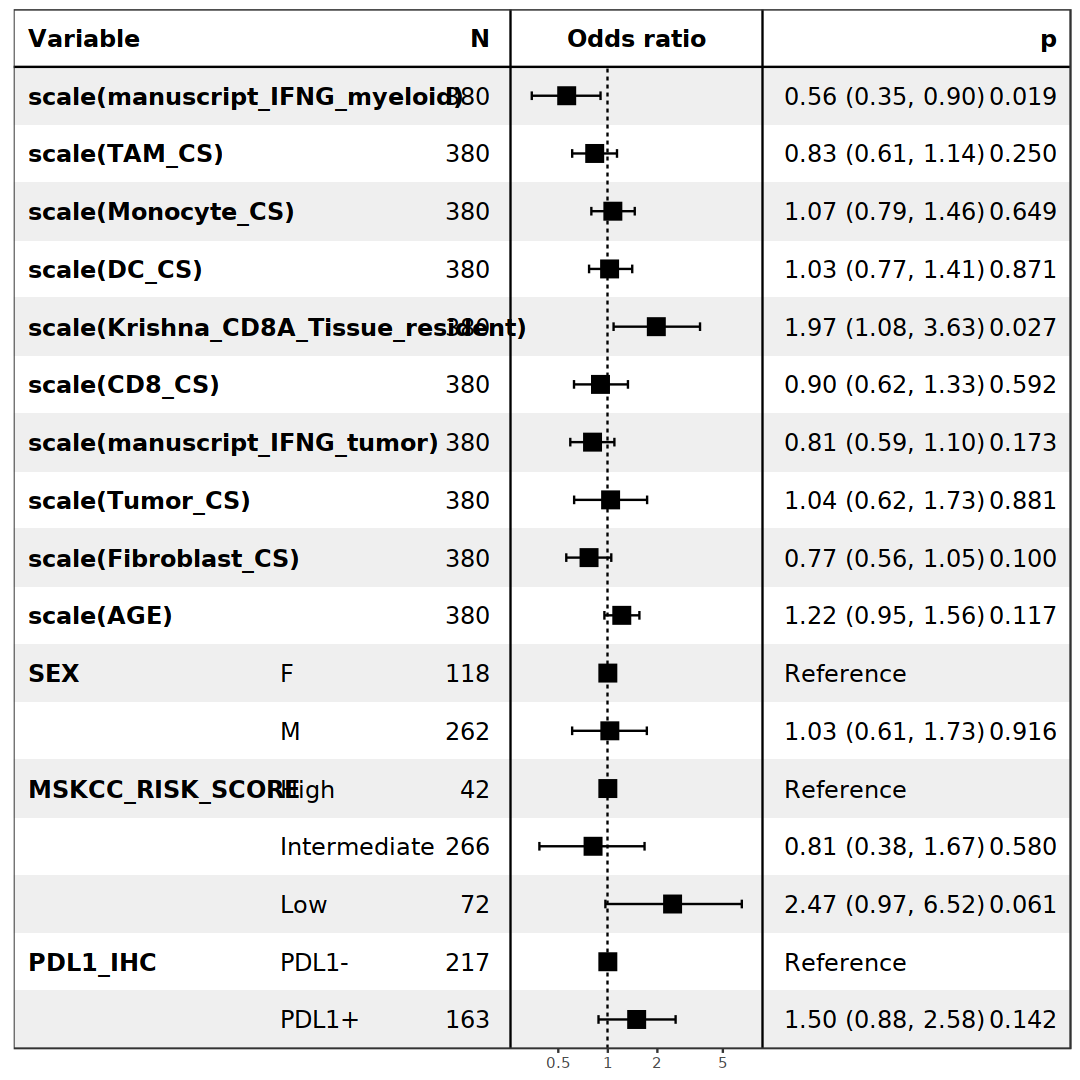

In [12]:
options(repr.plot.width=9, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = atezo_bev)
summary(mylogit)
vif(mylogit)

imm151_plot = forest_model(mylogit, panels,recalculate_width = F)
imm151_plot

### JAV101


 CB NCB 
239  96 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, 
    family = "binomial", data = avel_axit)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3615  -0.9608   0.6215   0.8209   1.7397  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -0.614522   0.466390  -1.318 0.187632    
scale(manuscript_IFNG_myeloid)      -0.705695   0.322494  -2.188 0.028652 *  
scale(TAM_CS)                        0.121843   0.185568   0.657 0.511439    
scale(Monocyte_CS)                   0.103238   0.165753   0.623 0.533388    
scale(DC_CS)                         0.001095   0.151486   0.007 0.994232    
scale(Krishna_CD8A_Tissue_resident)  0.713462   

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      6.334491 1  2.516842       
scale(TAM_CS)                       1.945903 1  1.394956       
scale(Monocyte_CS)                  1.608539 1  1.268282       
scale(DC_CS)                        1.423300 1  1.193022       
scale(Krishna_CD8A_Tissue_resident) 7.737760 1  2.781683       
scale(CD8_CS)                       1.786839 1  1.336727       
scale(manuscript_IFNG_tumor)        2.168167 1  1.472470       
scale(Tumor_CS)                     3.635668 1  1.906743       
scale(Fibroblast_CS)                2.053535 1  1.433016       
scale(Age)                          1.054531 1  1.026903       
Sex                                 1.055507 1  1.027379       
MSKCC                               1.131615 2  1.031394       
PDL1_status_v1                      1.198706 1  1.094854

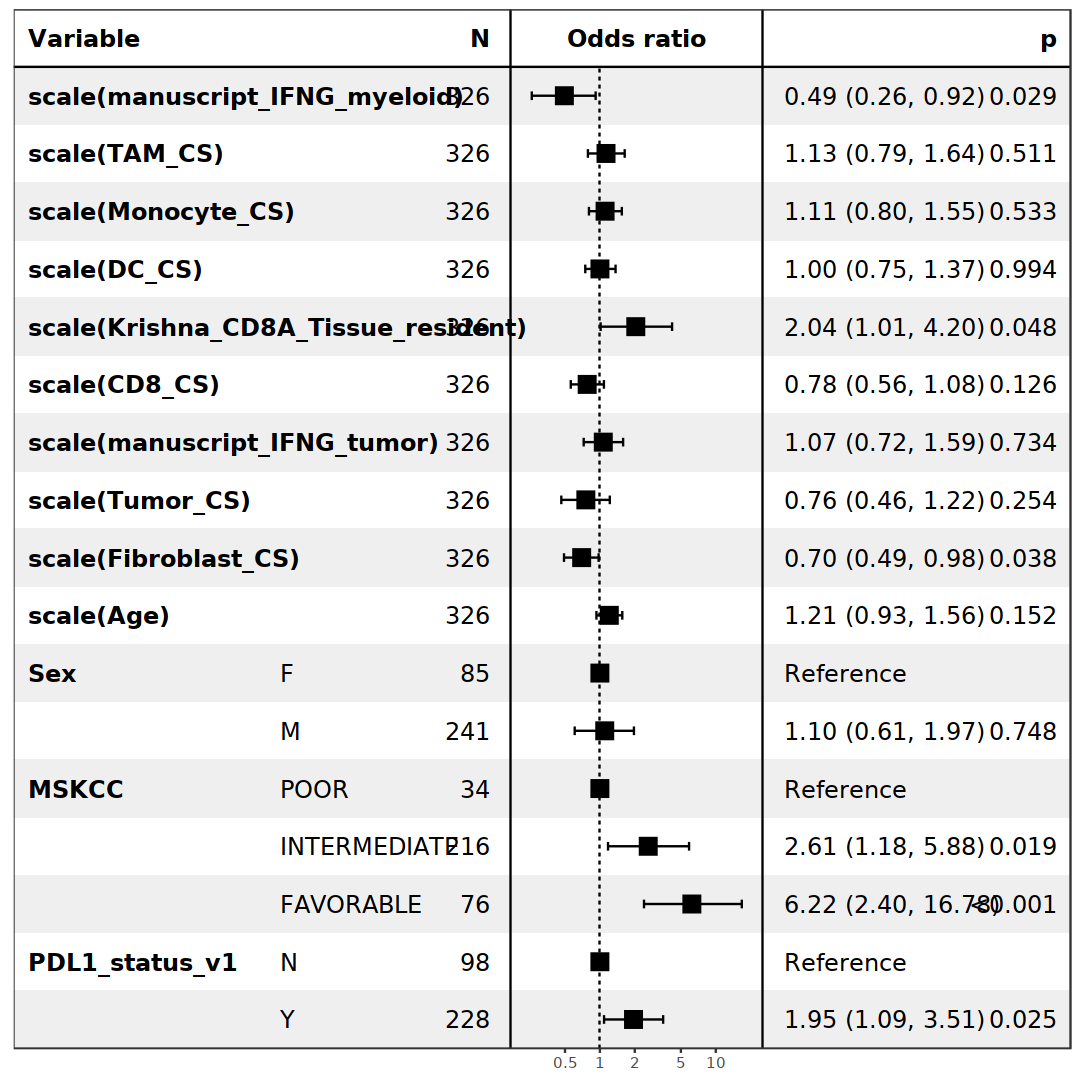

In [13]:
options(repr.plot.width=9, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = avel_axit)
summary(mylogit)
vif(mylogit)

jav101_plot = forest_model(mylogit, panels,recalculate_width = F)
jav101_plot

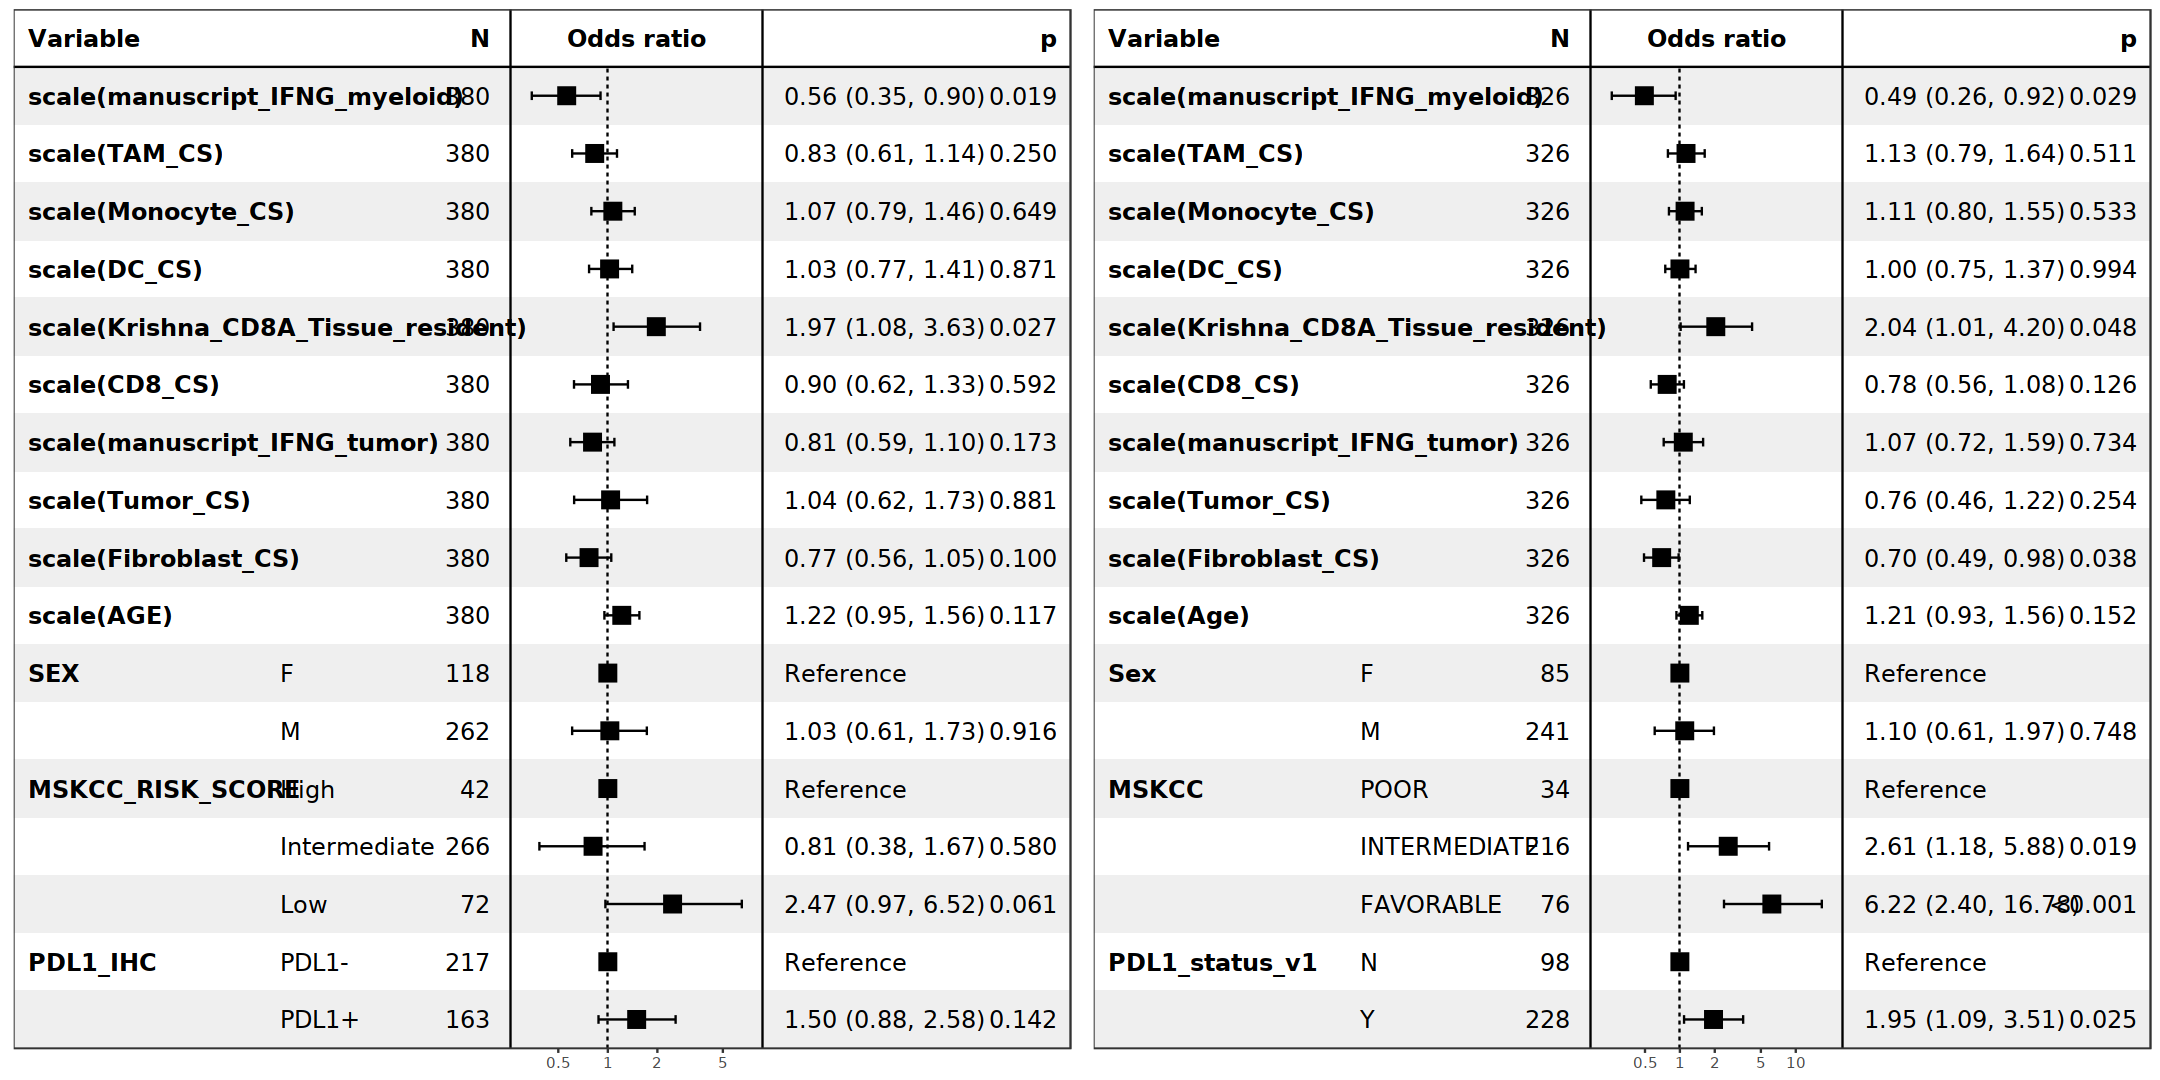

In [14]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(imm151_plot, jav101_plot)

ggsave("../../Supp_Figures_Final/Figure_S6/FigureS6C_D_LogisticRegression_IMM151_JAV101_ICB_Scaled.pdf",width = 18, height = 9)

### Supp Figure 6E-F. Logistic regression models for CB vs NCB in TKI arm of IMM151 and JAV101 (IFNG signatures) <a name="3"></a>

In [15]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Odds ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### IMM151


 CB NCB 
255 123 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + 
    PDL1_IHC, family = "binomial", data = sunitinib)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3297  -0.9228   0.6007   0.8122   2.1441  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -1.04204    0.49350  -2.112   0.0347 *  
scale(manuscript_IFNG_myeloid)       0.33919    0.26935   1.259   0.2079    
scale(TAM_CS)                       -0.25851    0.16367  -1.579   0.1142    
scale(Monocyte_CS)                  -0.14346    0.14801  -0.969   0.3324    
scale(DC_CS)                         0.04244    0.15407   0.275   0.7830    
scale(Krishna_CD8A_Tissue_resident)  0.40702    0

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      5.166212 1  2.272930       
scale(TAM_CS)                       1.827928 1  1.352009       
scale(Monocyte_CS)                  1.518255 1  1.232175       
scale(DC_CS)                        1.511061 1  1.229252       
scale(Krishna_CD8A_Tissue_resident) 7.383252 1  2.717214       
scale(CD8_CS)                       3.058204 1  1.748772       
scale(manuscript_IFNG_tumor)        1.611038 1  1.269267       
scale(Tumor_CS)                     3.994240 1  1.998560       
scale(Fibroblast_CS)                1.826647 1  1.351535       
scale(AGE)                          1.077922 1  1.038230       
SEX                                 1.151191 1  1.072936       
MSKCC_RISK_SCORE                    1.072925 2  1.017753       
PDL1_IHC                            1.405338 1  1.185469

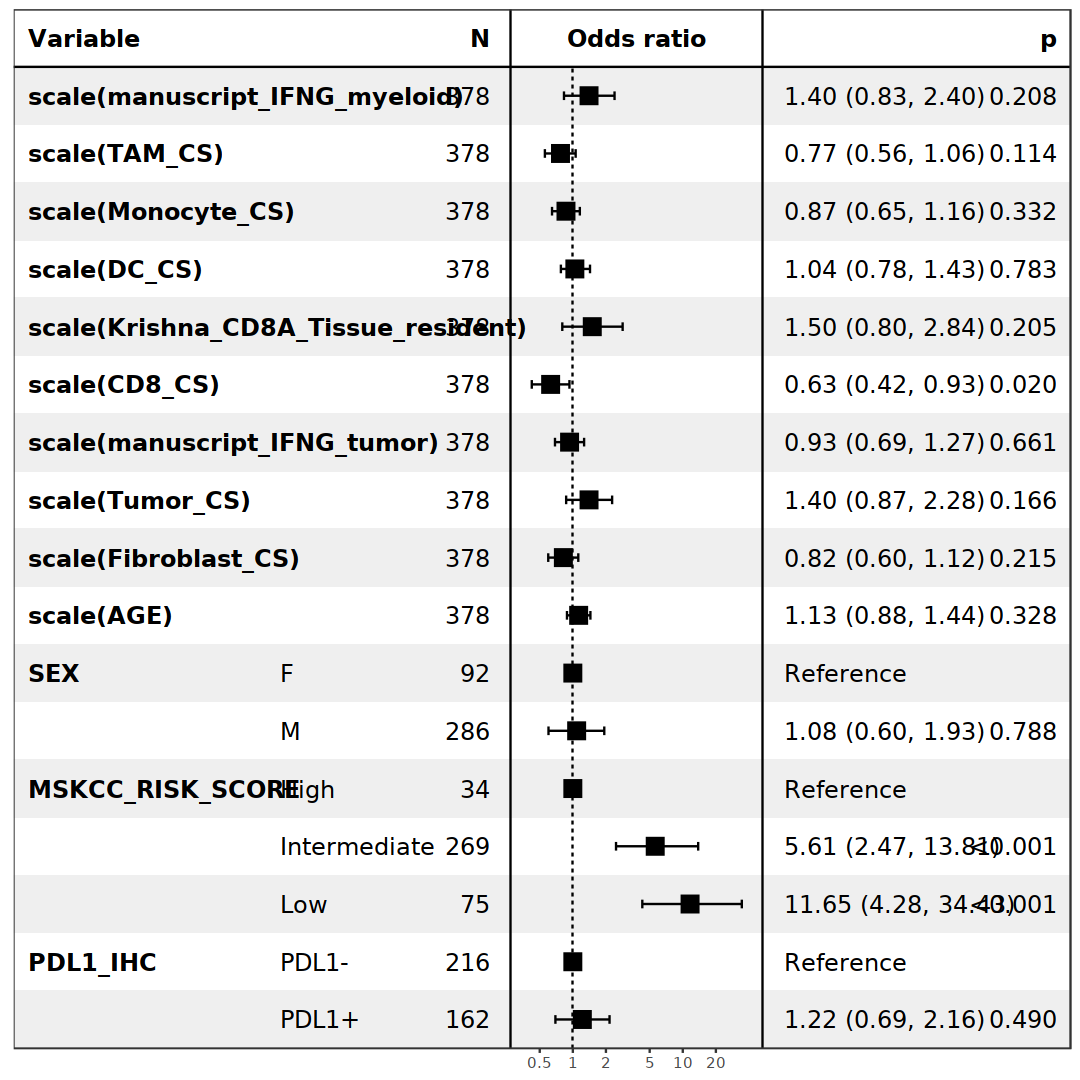

In [16]:
options(repr.plot.width=9, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = sunitinib)
summary(mylogit)
vif(mylogit)

imm151_plot = forest_model(mylogit, panels,recalculate_width = F)
imm151_plot

### JAV101


 CB NCB 
182 161 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, 
    family = "binomial", data = sunitinib)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9696  -1.1414   0.6366   1.0943   1.9742  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -1.17963    0.55557  -2.123 0.033731 *  
scale(manuscript_IFNG_myeloid)       0.26436    0.30078   0.879 0.379435    
scale(TAM_CS)                       -0.06943    0.14754  -0.471 0.637939    
scale(Monocyte_CS)                  -0.11769    0.14534  -0.810 0.418098    
scale(DC_CS)                         0.31076    0.15766   1.971 0.048717 *  
scale(Krishna_CD8A_Tissue_resident)  0.05078    0.3230

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      6.698067 1  2.588062       
scale(TAM_CS)                       1.654561 1  1.286297       
scale(Monocyte_CS)                  1.655209 1  1.286549       
scale(DC_CS)                        1.402567 1  1.184300       
scale(Krishna_CD8A_Tissue_resident) 7.716976 1  2.777945       
scale(CD8_CS)                       1.877638 1  1.370269       
scale(manuscript_IFNG_tumor)        2.008667 1  1.417274       
scale(Tumor_CS)                     3.389869 1  1.841160       
scale(Fibroblast_CS)                1.685421 1  1.298238       
scale(Age)                          1.029677 1  1.014730       
Sex                                 1.046710 1  1.023088       
MSKCC                               1.086770 2  1.021020       
PDL1_status_v1                      1.170540 1  1.081915

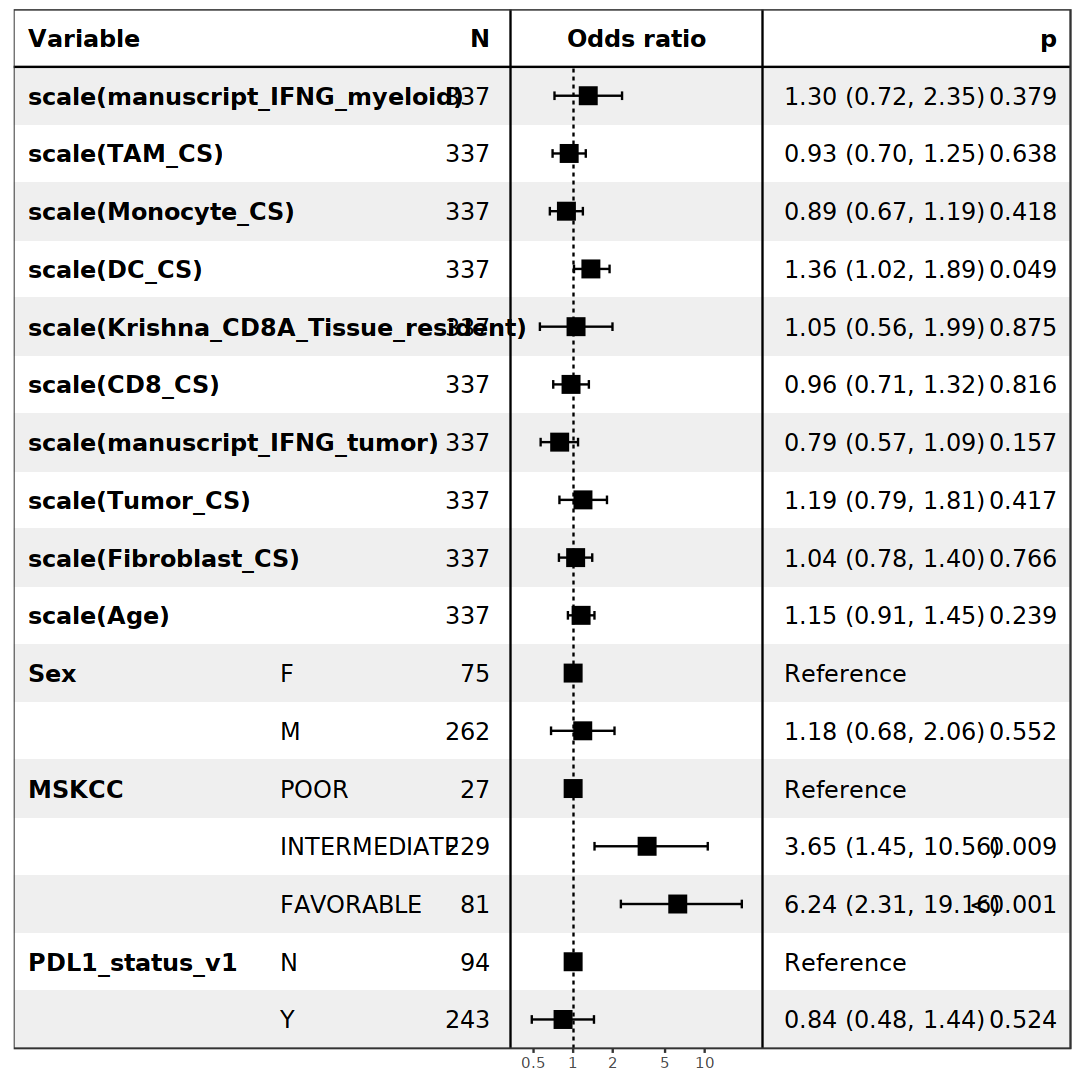

In [17]:
options(repr.plot.width=9, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = sunitinib)
summary(mylogit)
vif(mylogit)

jav101_plot = forest_model(mylogit, panels,recalculate_width = F)
jav101_plot

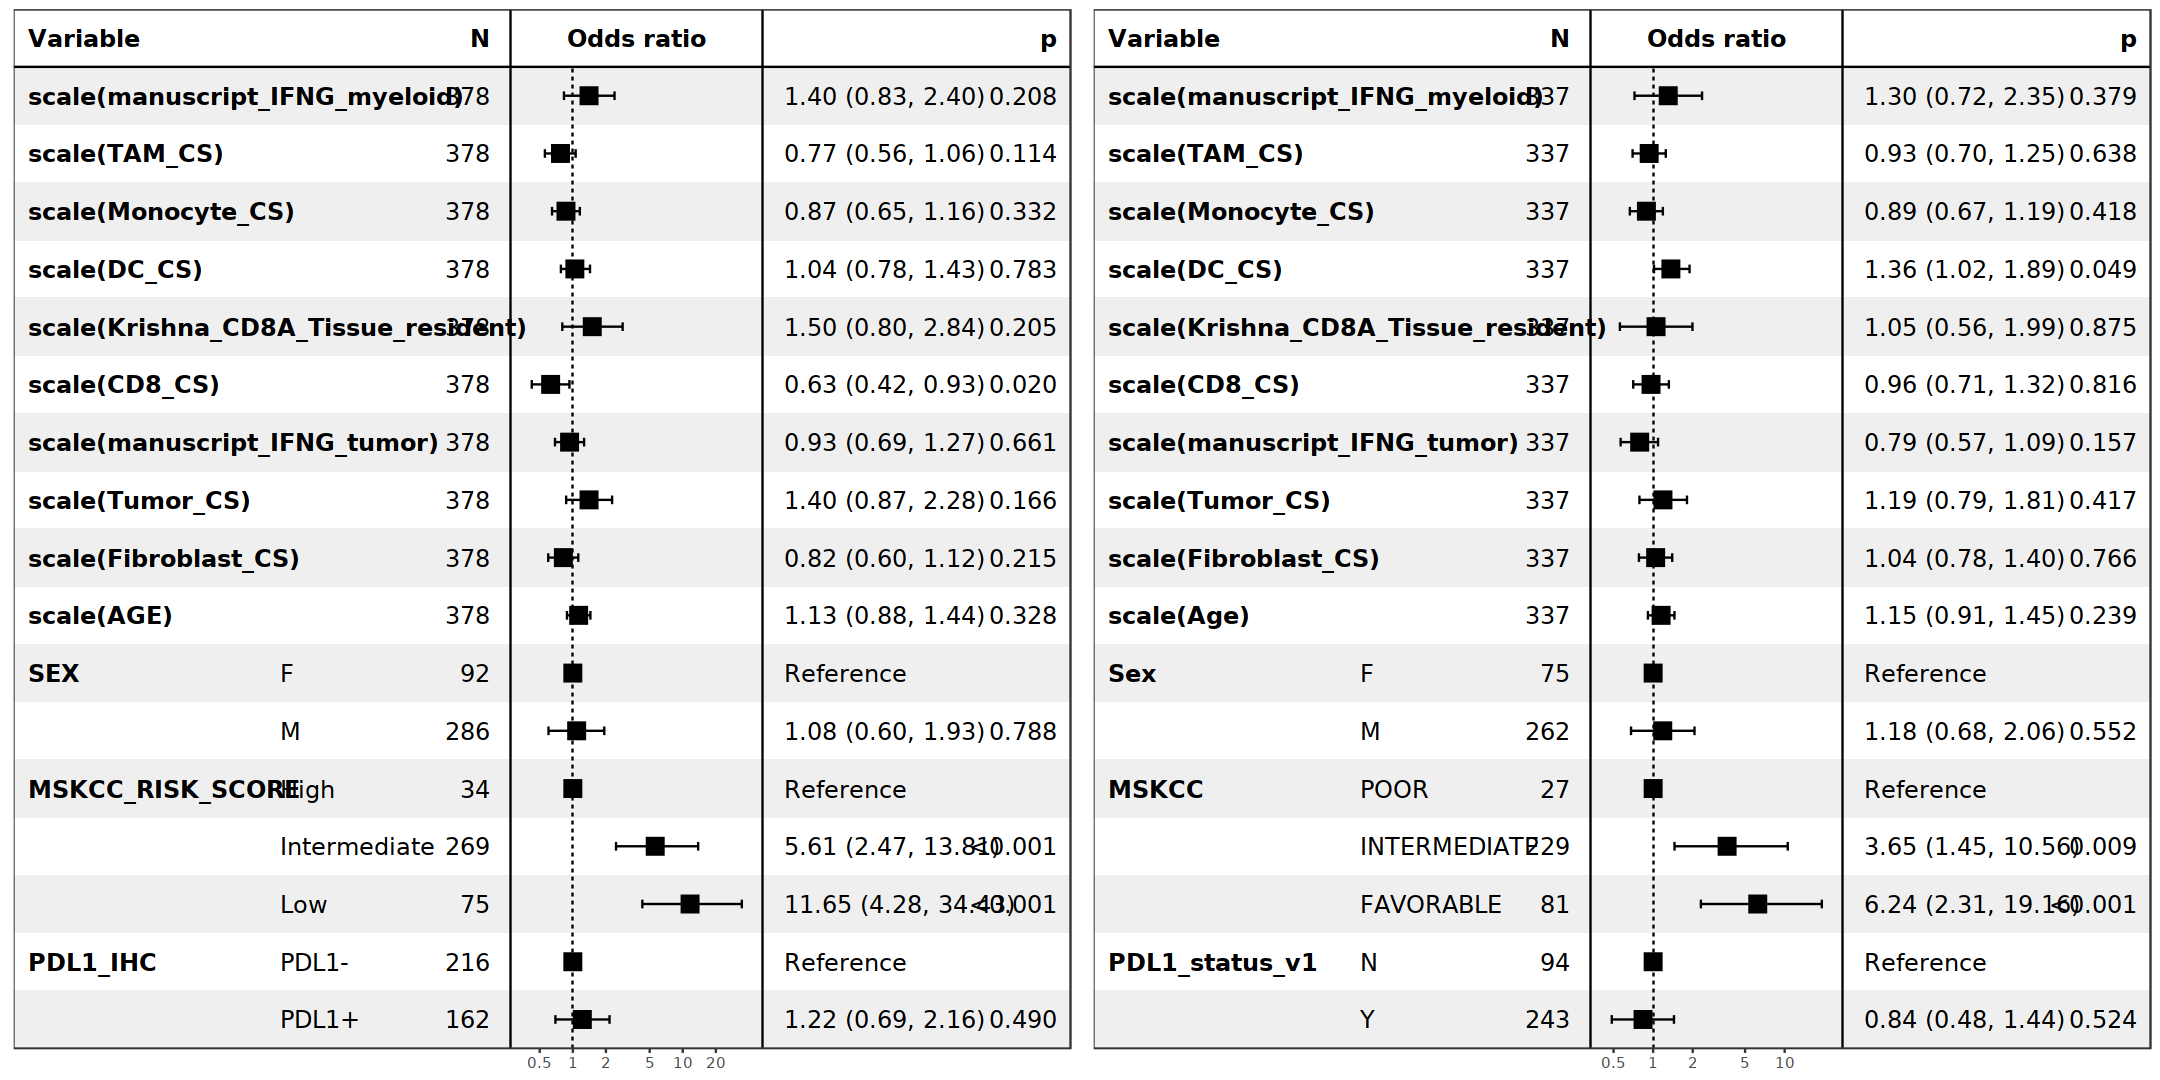

In [18]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(imm151_plot, jav101_plot)

ggsave("../../Supp_Figures_Final/Figure_S6/Figure6E_F_LogisticRegeression_IMM151_JAV101_TKI_Scaled.pdf",width = 18, height = 9)

### Supp Figure 6G-J. Cox models for PFS in IO+VEGF arm of IMM151 and JAV101 (Krishna_CD8A_Tissue_resident-high samples, stratified myeloid IFNG signaling) <a name="4"></a>

In [19]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Hazard ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### IMM151

In [20]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
263 117 

In [21]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
255 123 

### First, find optimal cutoff for Krishna_CD8A_Tissue_resident. Then within that subset, binarize myeloid IFNG score 

cutpoint  statistic
Krishna_CD8A_Tissue_resident -4.336211 3.127211

$Krishna_CD8A_Tissue_resident


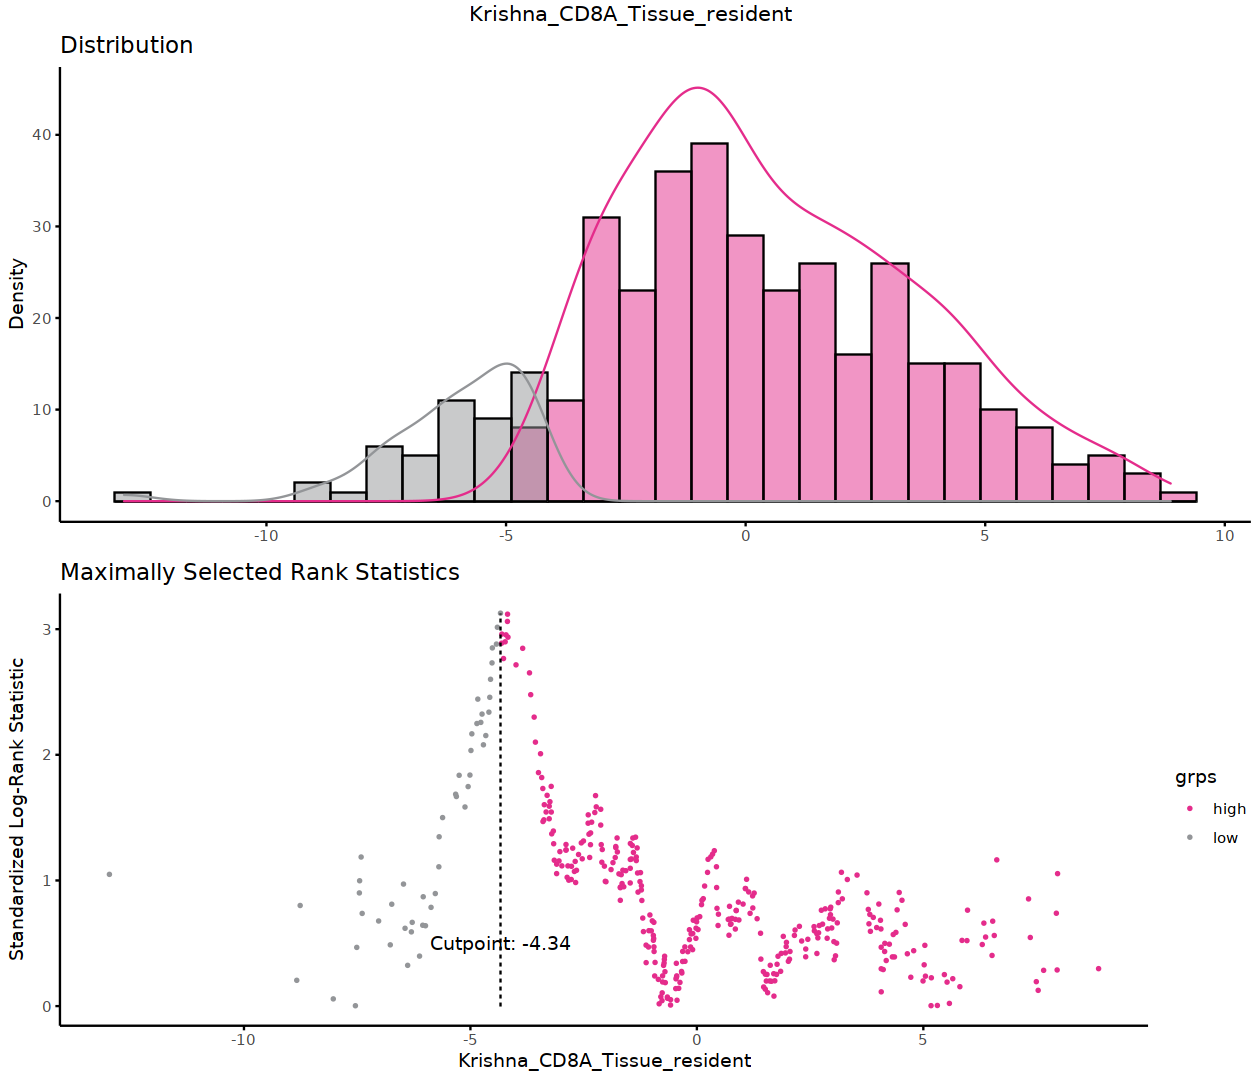

In [22]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_cd8 <- surv_cutpoint(atezo_bev, time = "PFS_MONTHS", event = "PFS_CENSOR",minprop = 0,
   variables = c("Krishna_CD8A_Tissue_resident"))
summary(res.cut_cd8)

plot(res.cut_cd8, "Krishna_CD8A_Tissue_resident", palette = c("#e42c8b","#939598"))

In [23]:
atezo_bev_topcd8 = subset(atezo_bev, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(atezo_bev_topcd8)

[1]   331 25639

In [24]:
sunitinib_topcd8 = subset(sunitinib, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(sunitinib_topcd8)

[1]   342 25639

cutpoint  statistic
manuscript_IFNG_myeloid -1.879233 3.637437

$manuscript_IFNG_myeloid


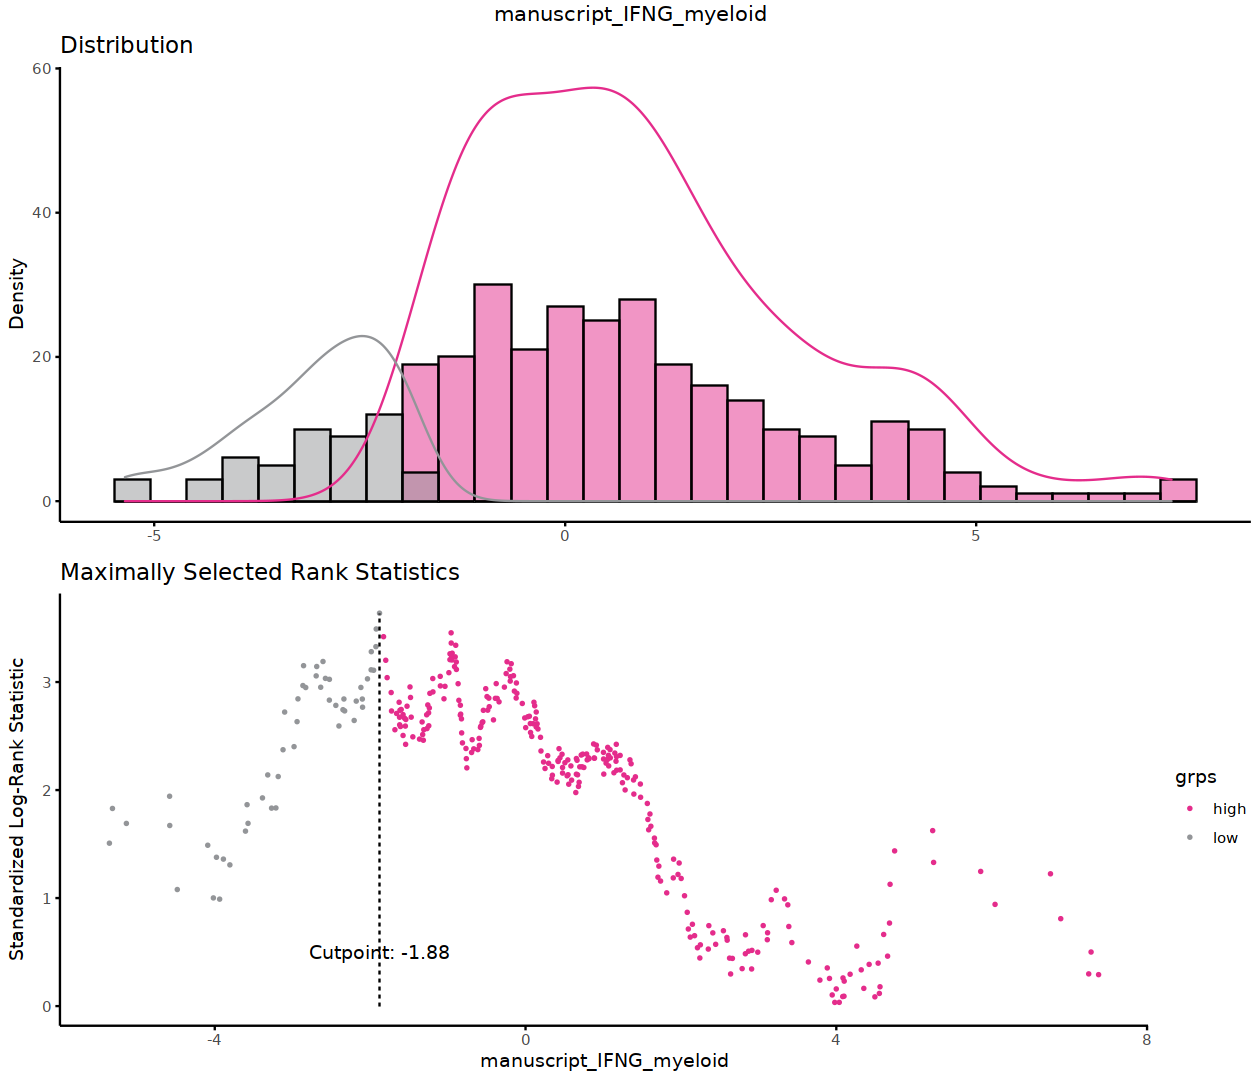

In [25]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_myeloid <- surv_cutpoint(atezo_bev_topcd8, time = "PFS_MONTHS", event = "PFS_CENSOR",minprop = 0,
   variables = c("manuscript_IFNG_myeloid"))
summary(res.cut_myeloid)

plot(res.cut_myeloid, "manuscript_IFNG_myeloid", palette = c("#e42c8b","#939598"))

In [26]:
res.cat <- surv_categorize(res.cut_myeloid)
head(res.cat)
dim(res.cat)
table(res.cat$manuscript_IFNG_myeloid)

PFS_MONTHS PFS_CENSOR manuscript_IFNG_myeloid
EA-c98e425b64 11.43       TRUE      high                   
EA-50a17b762a  9.76       TRUE      high                   
EA-503b2e1876 11.24      FALSE      low                    
EA-9be3b7c254 23.39      FALSE      low                    
EA-cce8886053  2.07       TRUE      high                   
EA-858e45ba5f 11.17       TRUE      high

[1] 331   3


high  low 
 279   52 

In [27]:
res.cut_myeloid$cutpoint$cutpoint

[1] -1.879233

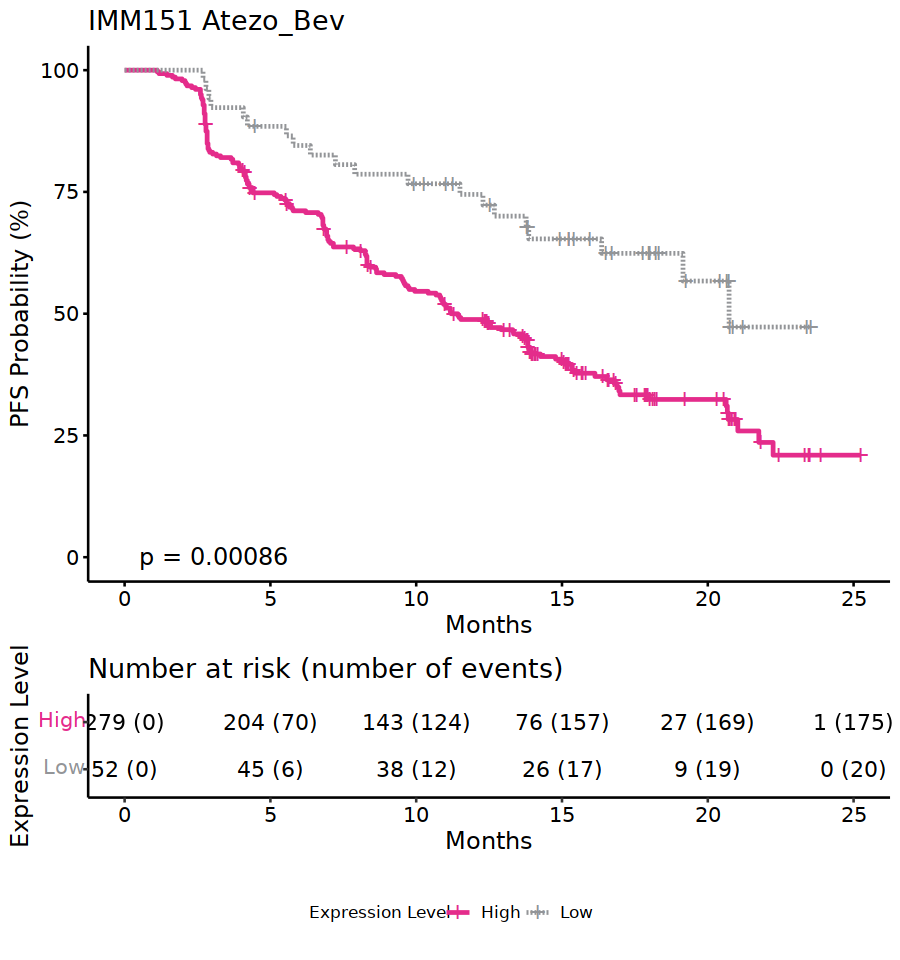

In [28]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS_MONTHS, PFS_CENSOR) ~ manuscript_IFNG_myeloid, data = res.cat)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T,palette = c("#e42c8b","#939598"))
io = ggsurvplot(fit,title = "IMM151 Atezo_Bev",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low")
    )
io

In [29]:
sunitinib_topcd8 = mutate(sunitinib_topcd8, manuscript_IFNG_myeloid_group = ifelse(manuscript_IFNG_myeloid > res.cut_myeloid$cutpoint$cutpoint, "high","low"))
sunitinib_topcd8$manuscript_IFNG_myeloid_group = factor(sunitinib_topcd8$manuscript_IFNG_myeloid_group, levels = c("high","low"))
table(sunitinib_topcd8$manuscript_IFNG_myeloid_group)


high  low 
 299   43 

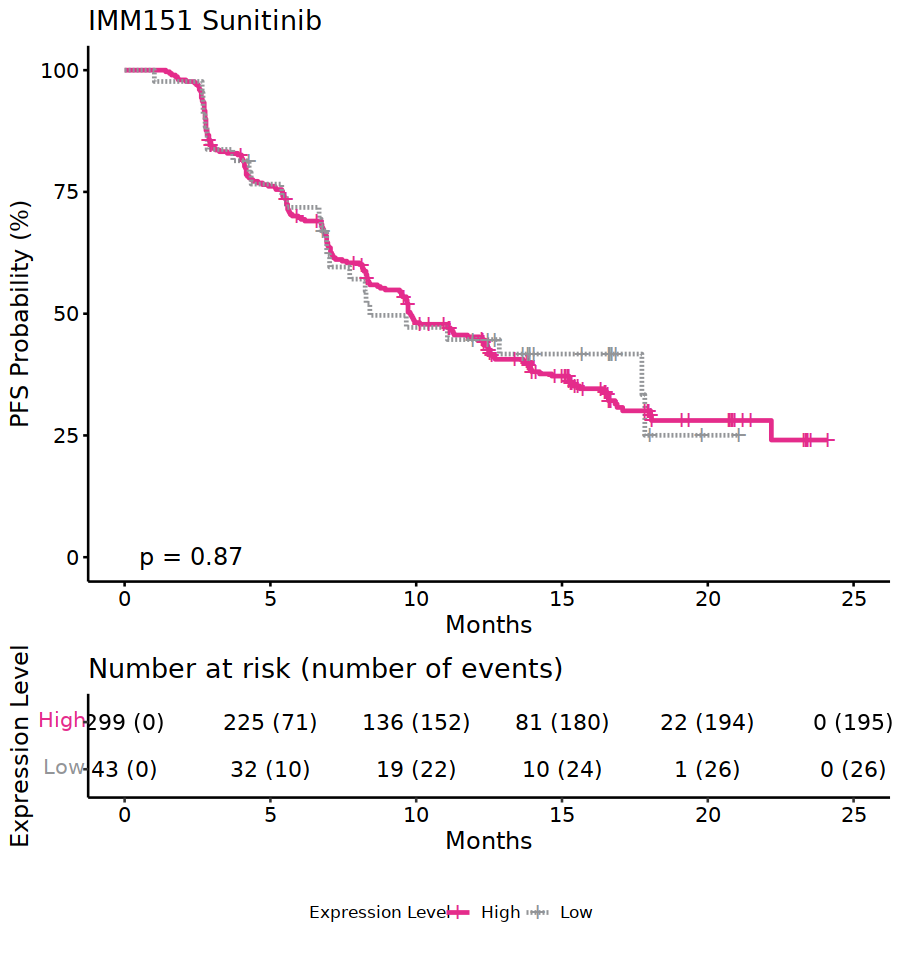

In [30]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS_MONTHS, PFS_CENSOR) ~ manuscript_IFNG_myeloid_group, data = sunitinib_topcd8)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T, palette = c("#e42c8b","#939598"))

tki = ggsurvplot(fit,title = "IMM151 Sunitinib",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low")
    )
tki

### Let's check if this binarized IFNG myeloid score is significantly associated with worse PFS under a multivariate Cox

In [31]:
setequal(row.names(res.cat), row.names(atezo_bev_topcd8))

[1] TRUE

In [32]:
atezo_bev_topcd8$manuscript_IFNG_myeloid_group = res.cat$manuscript_IFNG_myeloid
atezo_bev_topcd8$manuscript_IFNG_myeloid_group = factor(atezo_bev_topcd8$manuscript_IFNG_myeloid_group, levels = c("low","high"))
table(atezo_bev_topcd8$manuscript_IFNG_myeloid_group)


 low high 
  52  279 

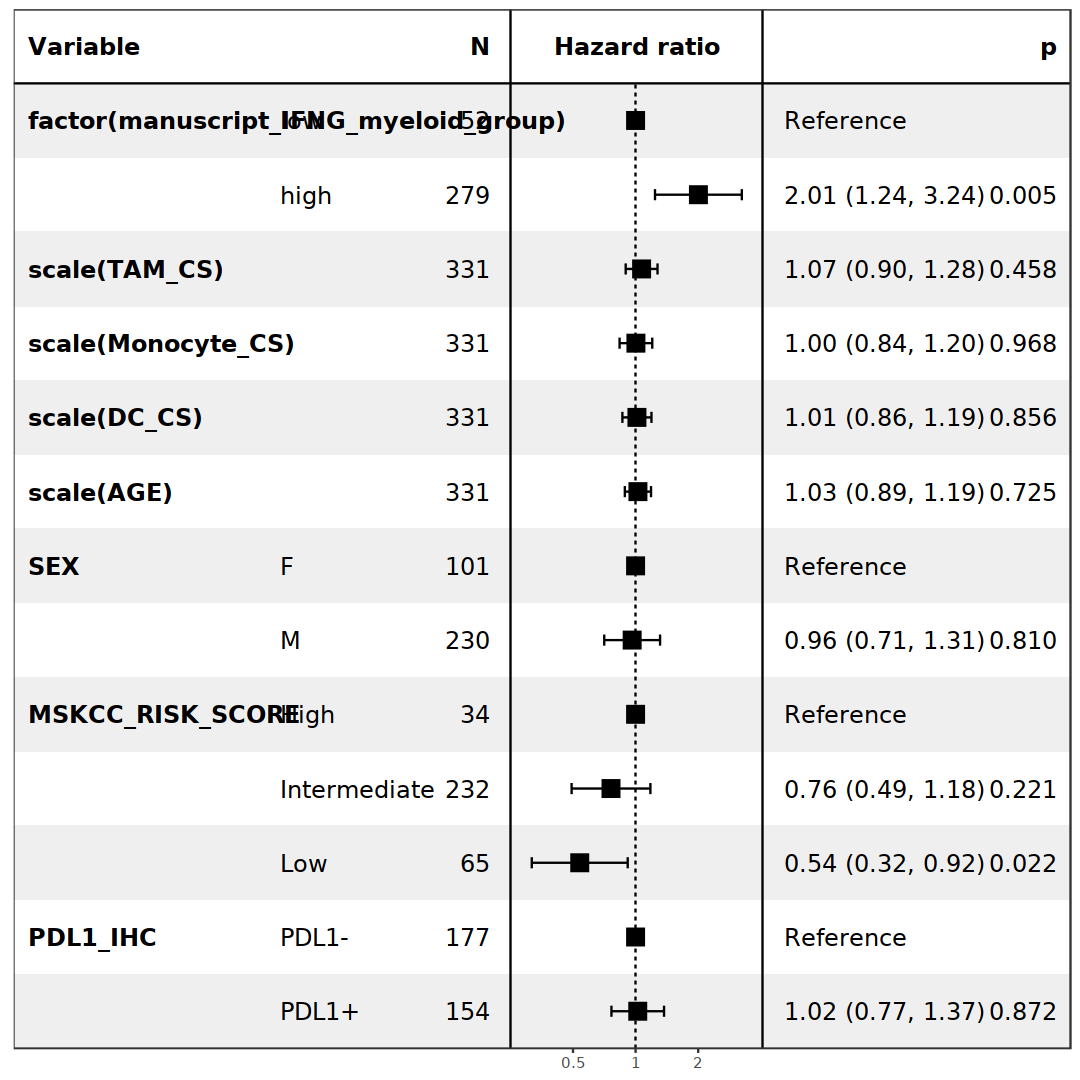

In [33]:
options(repr.plot.width=9, repr.plot.height=9)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev_topcd8)
imm151_icb_plot = forest_model(res.cox, panels,recalculate_width = F)
imm151_icb_plot

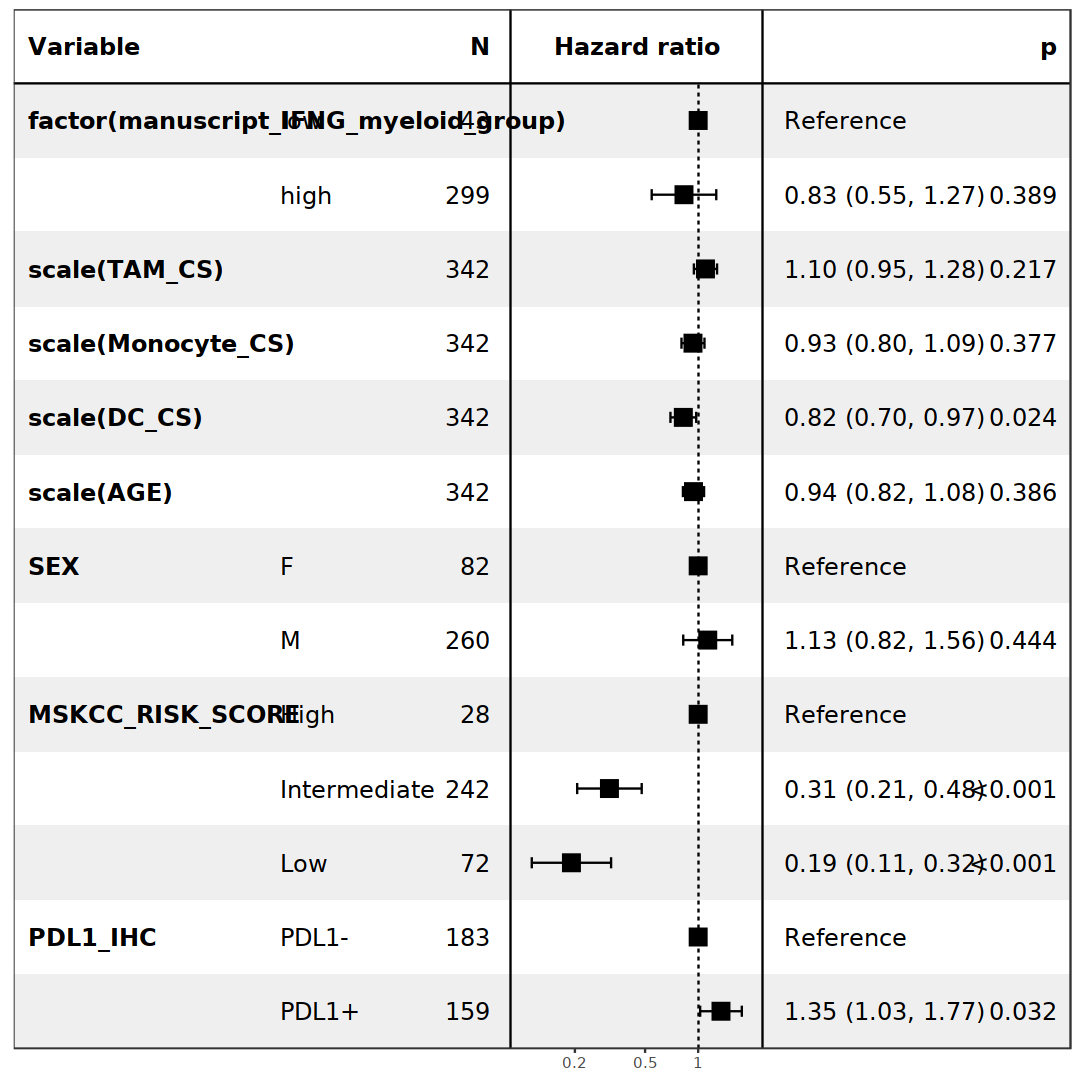

In [34]:
options(repr.plot.width=9, repr.plot.height=9)

sunitinib_topcd8$manuscript_IFNG_myeloid_group = relevel(sunitinib_topcd8$manuscript_IFNG_myeloid_group, ref = "low")

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib_topcd8)
imm151_tki_plot = forest_model(res.cox, panels,recalculate_width = F)
imm151_tki_plot

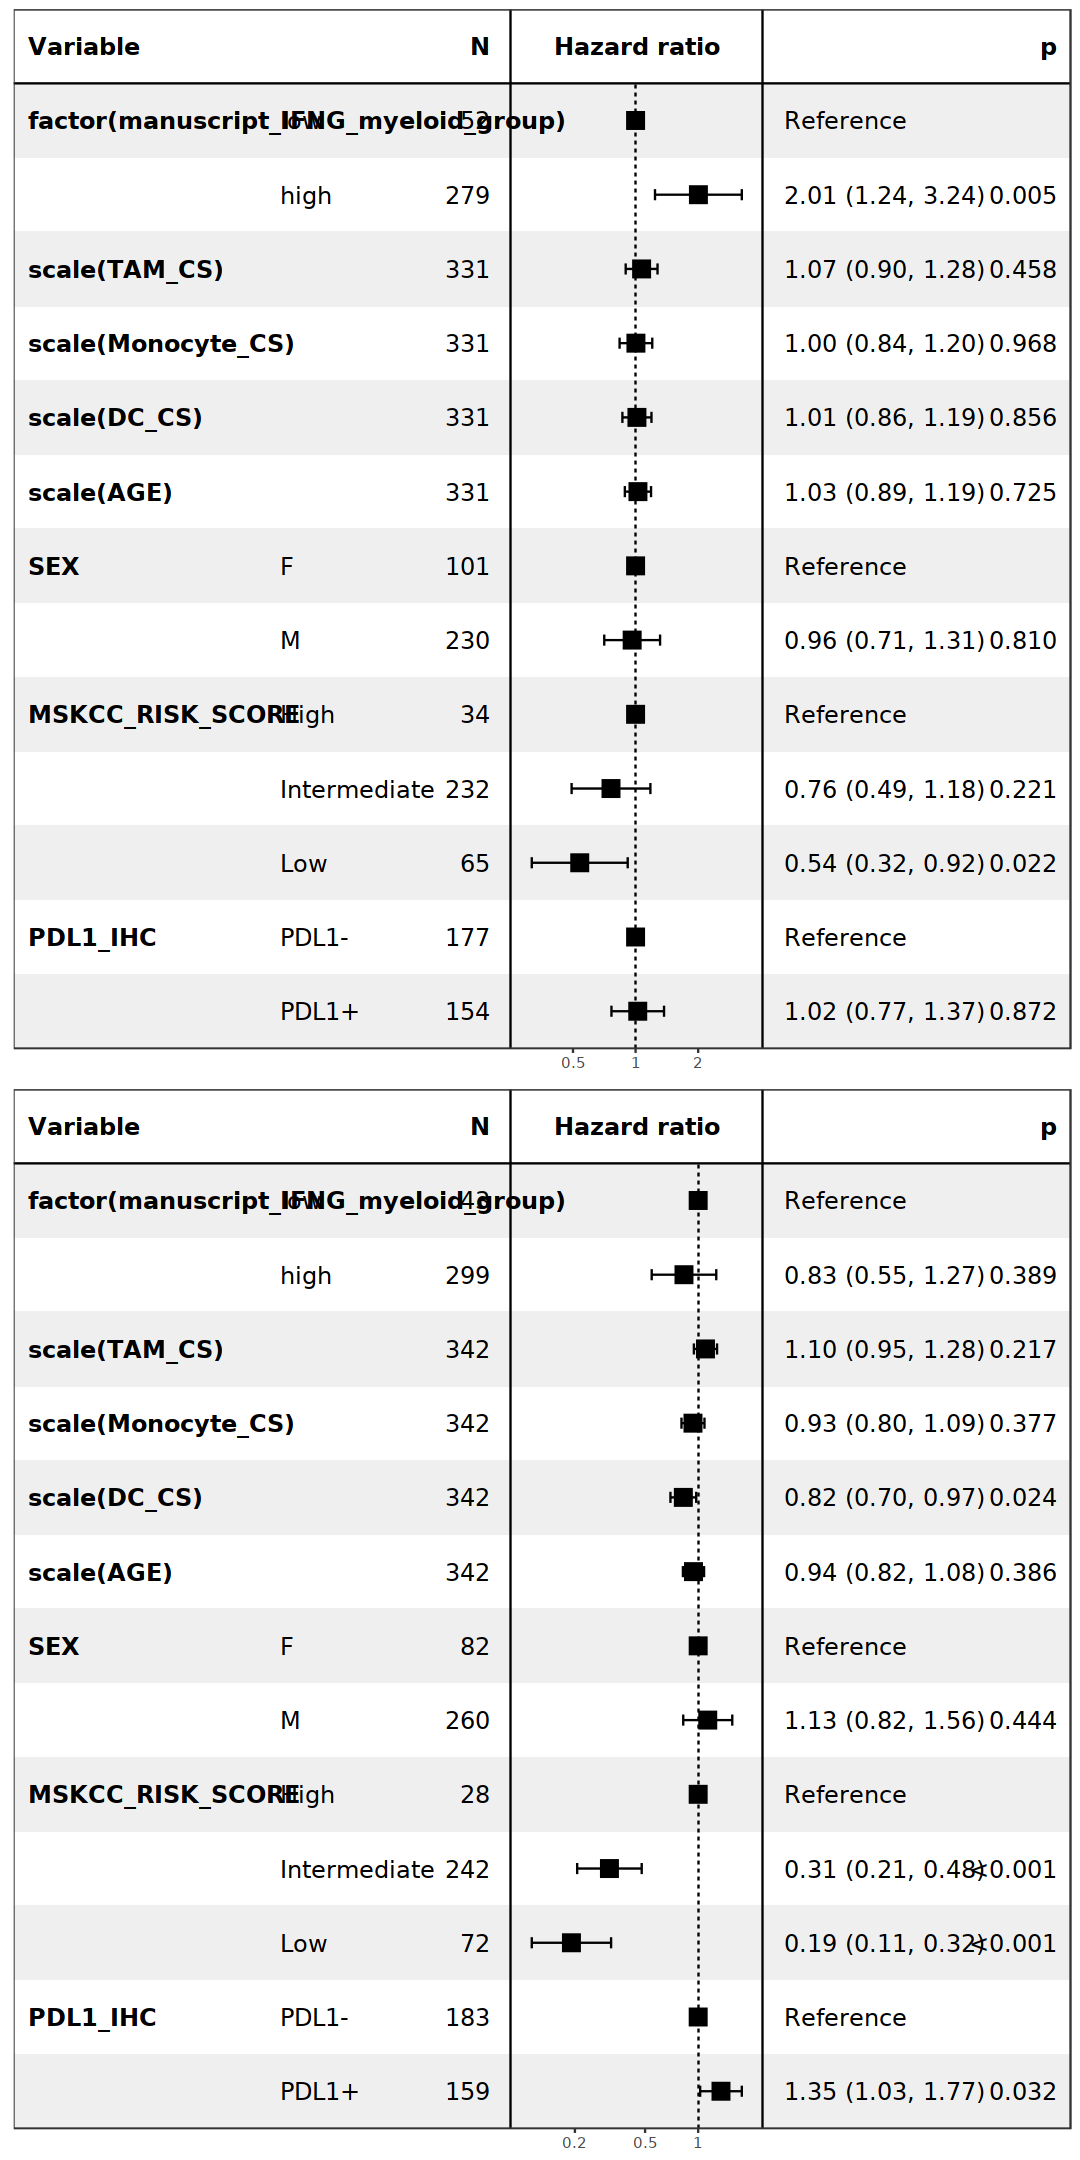

In [36]:
options(repr.plot.width=9, repr.plot.height=18)

ggarrange(imm151_icb_plot, imm151_tki_plot,ncol = 1)

ggsave("../../Supp_Figures_Final/Figure_S6/FigureS6G_I_Cox_CD8High_IMM151_ICB_TKI_Scaled.pdf",width = 9, height = 18)

### JAV101

In [37]:
options(repr.plot.width=10.5, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
239  96 

In [38]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
182 161 

### First, find optimal cutoff for Krishna_CD8A_Tissue_resident. Then within that subset, binarize myeloid IFNG score

cutpoint  statistic
Krishna_CD8A_Tissue_resident -2.855867 3.710634

$Krishna_CD8A_Tissue_resident


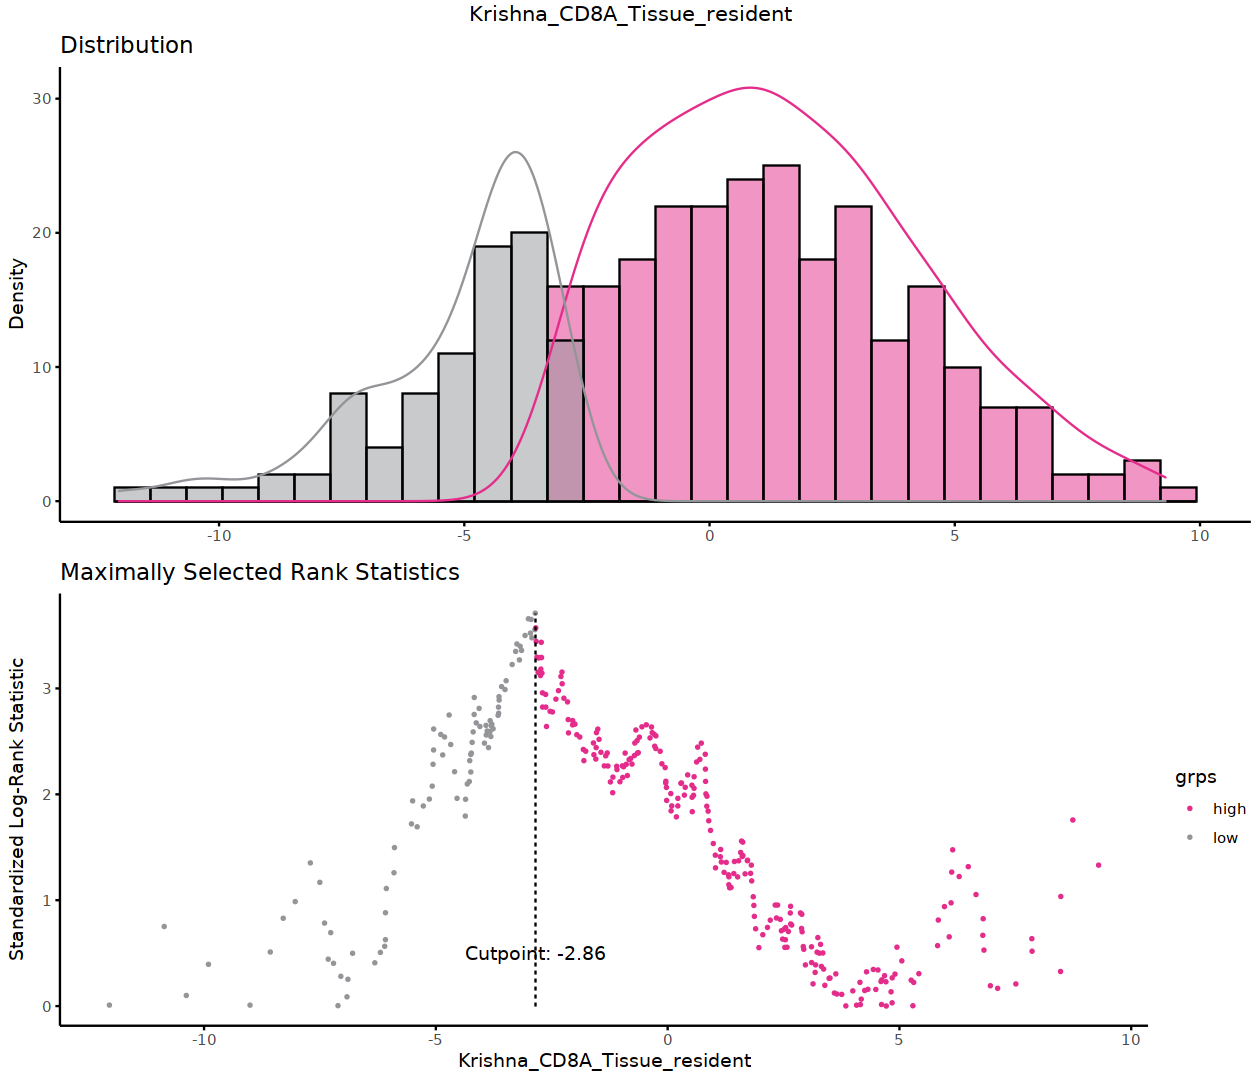

In [39]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_cd8 <- surv_cutpoint(avel_axit, time = "PFS", event = "PFS_CNSR",minprop = 0,
   variables = c("Krishna_CD8A_Tissue_resident"))
summary(res.cut_cd8)

plot(res.cut_cd8, "Krishna_CD8A_Tissue_resident", palette = c("#e42c8b","#939598"))

In [40]:
res.cut_cd8$cutpoint$cutpoint

[1] -2.855867

In [41]:
avel_axit_topcd8 = subset(avel_axit, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(avel_axit_topcd8)

[1]   245 40348

In [42]:
sunitinib_topcd8 = subset(sunitinib, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(sunitinib_topcd8)

[1]   275 40348

cutpoint  statistic
manuscript_IFNG_myeloid -1.283223 2.767251

$manuscript_IFNG_myeloid


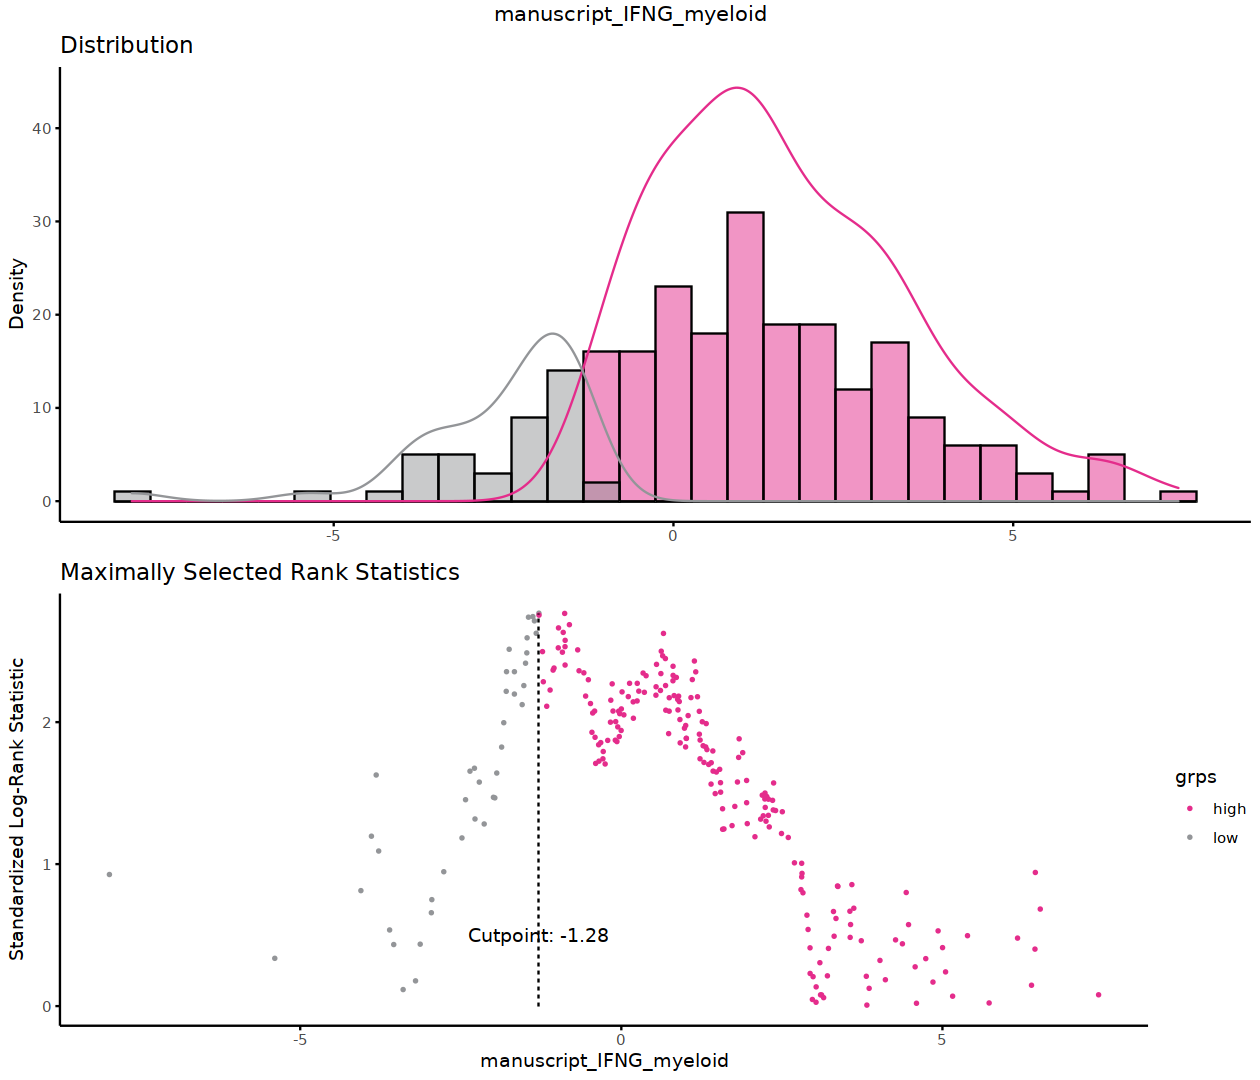

In [43]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_myeloid <- surv_cutpoint(avel_axit_topcd8, time = "PFS", event = "PFS_CNSR",minprop = 0,
   variables = c("manuscript_IFNG_myeloid"))
summary(res.cut_myeloid)

plot(res.cut_myeloid, "manuscript_IFNG_myeloid", palette = c("#e42c8b","#939598"))

In [44]:
res.cat <- surv_categorize(res.cut_myeloid)
head(res.cat)
dim(res.cat)
table(res.cat$manuscript_IFNG_myeloid)

PFS       PFS_CNSR manuscript_IFNG_myeloid
10011001_6203185783  1.379877 1        low                    
10011015_6204820848  2.891170 1        high                   
10011017_6204067222 18.135524 0        high                   
10011020_6204820845  1.412731 1        low                    
10011021_6204820844  3.318275 0        low                    
10011027_6204067225  2.891170 1        high

[1] 245   3


high  low 
 204   41 

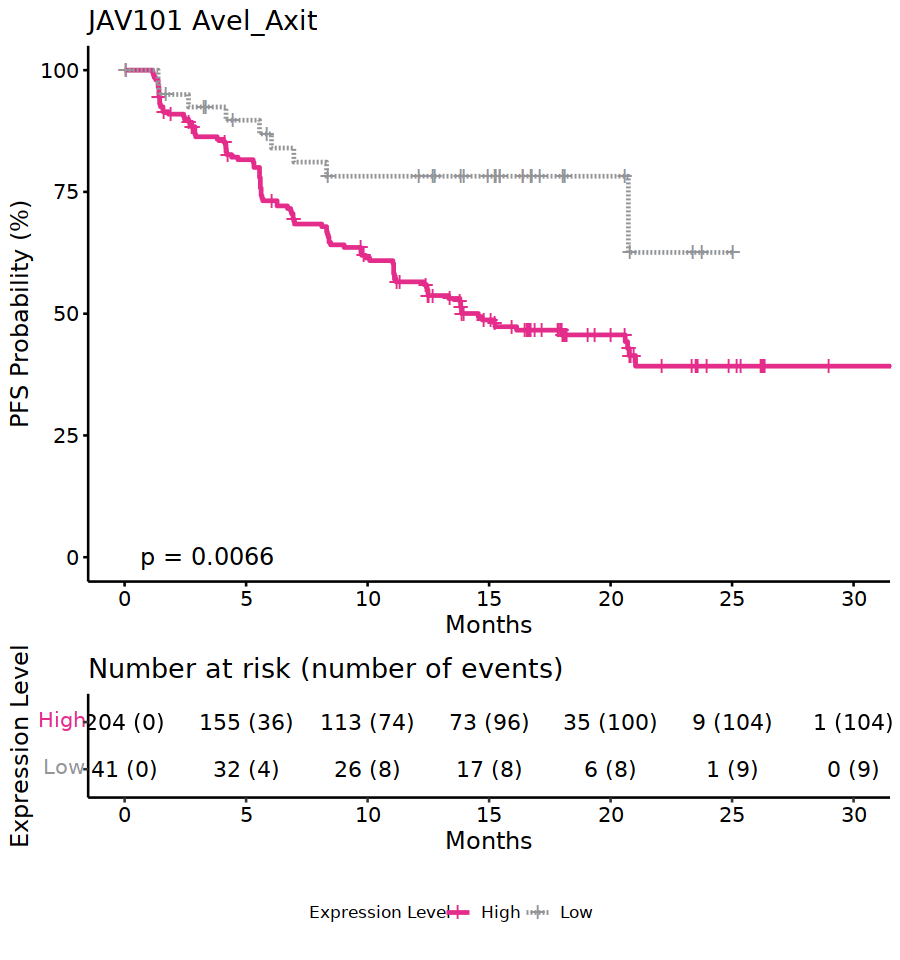

In [45]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS, PFS_CNSR) ~ manuscript_IFNG_myeloid, data = res.cat)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T,palette = c("#e42c8b","#939598"))
io = ggsurvplot(fit,title = "JAV101 Avel_Axit",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low"),
                break.x.by = 5
    )
io

In [46]:
sunitinib_topcd8 = mutate(sunitinib_topcd8, manuscript_IFNG_myeloid_group = ifelse(manuscript_IFNG_myeloid > res.cut_myeloid$cutpoint$cutpoint, "high","low"))
sunitinib_topcd8$manuscript_IFNG_myeloid_group = factor(sunitinib_topcd8$manuscript_IFNG_myeloid_group, levels = c("high","low"))
table(sunitinib_topcd8$manuscript_IFNG_myeloid_group)


high  low 
 235   40 

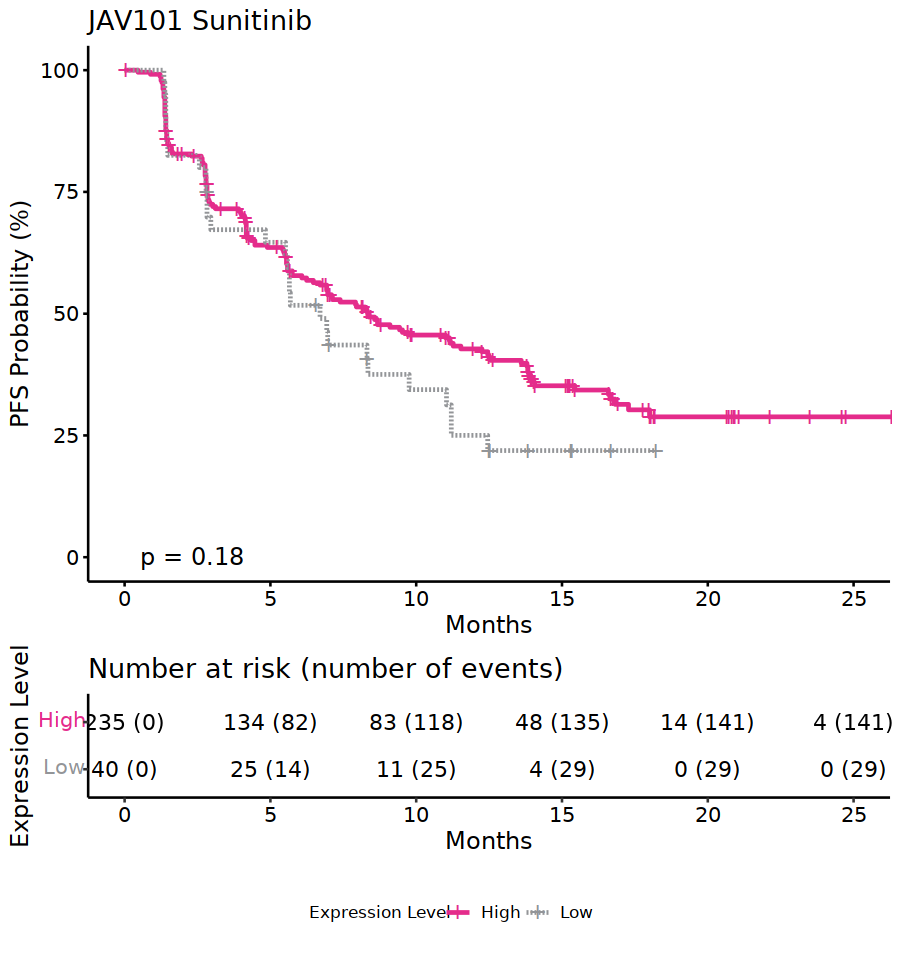

In [47]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS, PFS_CNSR) ~ manuscript_IFNG_myeloid_group, data = sunitinib_topcd8)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T, palette = c("#e42c8b","#939598"))

tki = ggsurvplot(fit,title = "JAV101 Sunitinib",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low")
    )
tki

### Let's check if this binarized IFNG myeloid score is significantly associated with worse PFS under a multivariate Cox

In [48]:
setequal(row.names(res.cat), row.names(avel_axit_topcd8))

[1] TRUE

In [49]:
avel_axit_topcd8$manuscript_IFNG_myeloid_group = res.cat$manuscript_IFNG_myeloid
avel_axit_topcd8$manuscript_IFNG_myeloid_group = factor(avel_axit_topcd8$manuscript_IFNG_myeloid_group, levels = c("low","high"))
table(avel_axit_topcd8$manuscript_IFNG_myeloid_group)


 low high 
  41  204 

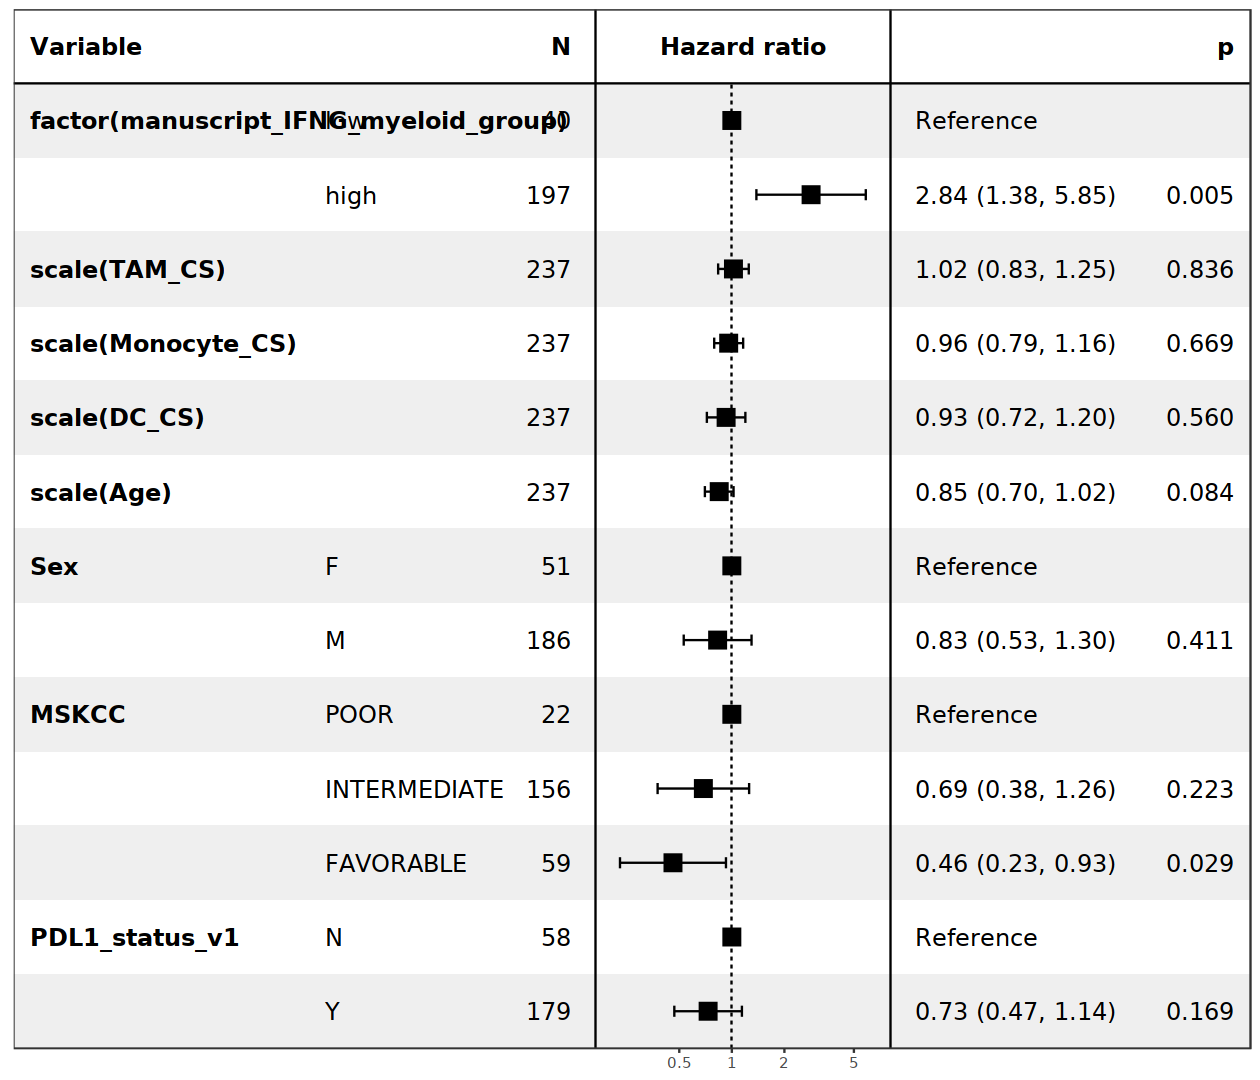

In [50]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit_topcd8)
jav101_icb_plot = forest_model(res.cox, panels,recalculate_width = F)
jav101_icb_plot

### Sunitinib arm

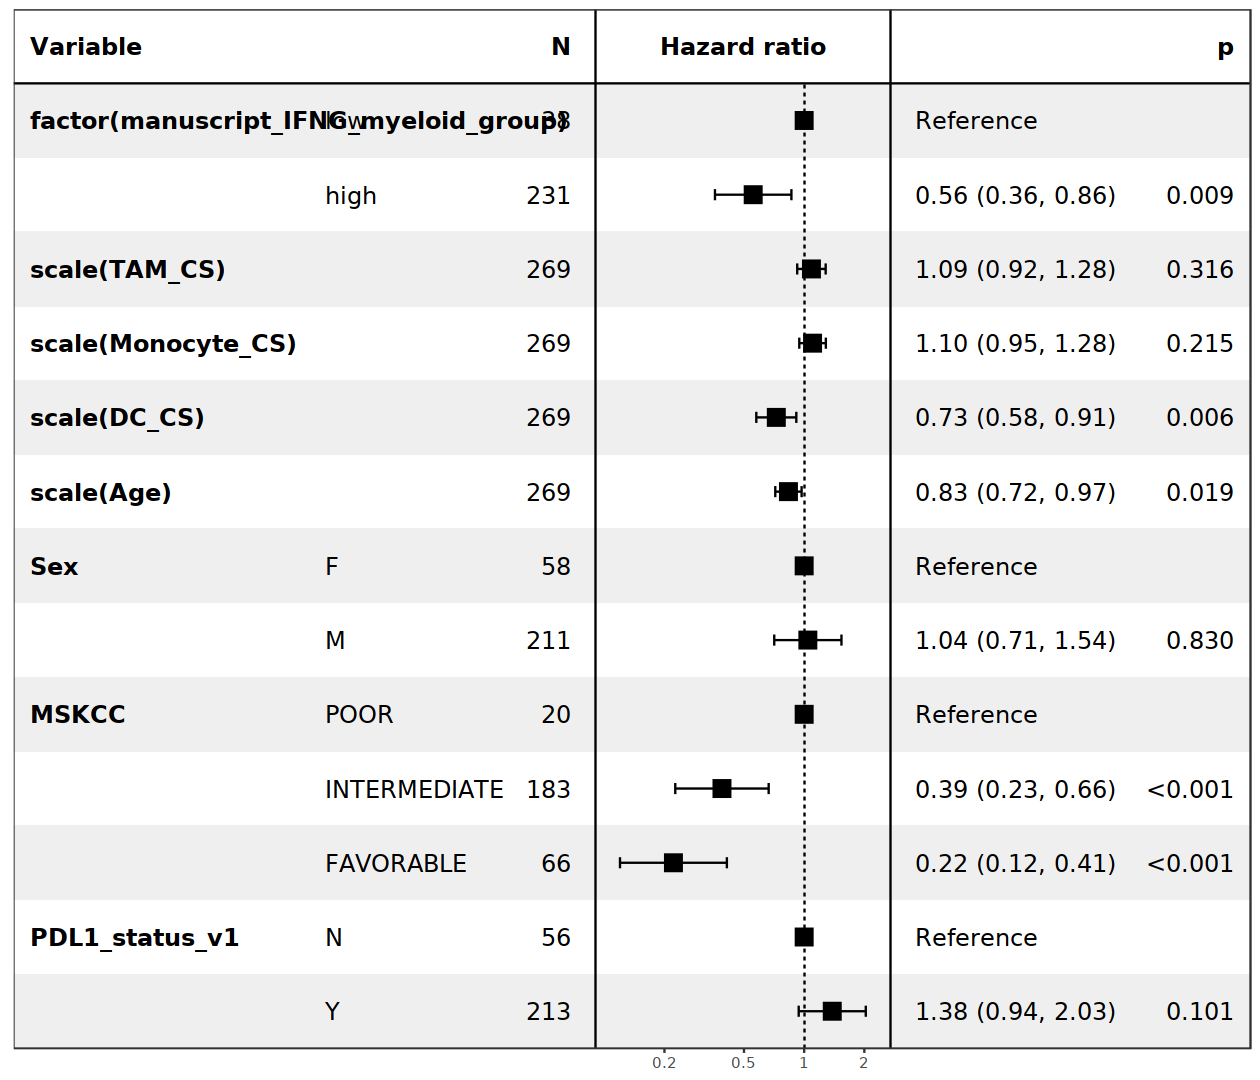

In [51]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib_topcd8$manuscript_IFNG_myeloid_group = relevel(sunitinib_topcd8$manuscript_IFNG_myeloid_group, ref = "low")

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib_topcd8)
jav101_tki_plot = forest_model(res.cox, panels,recalculate_width = F)
jav101_tki_plot

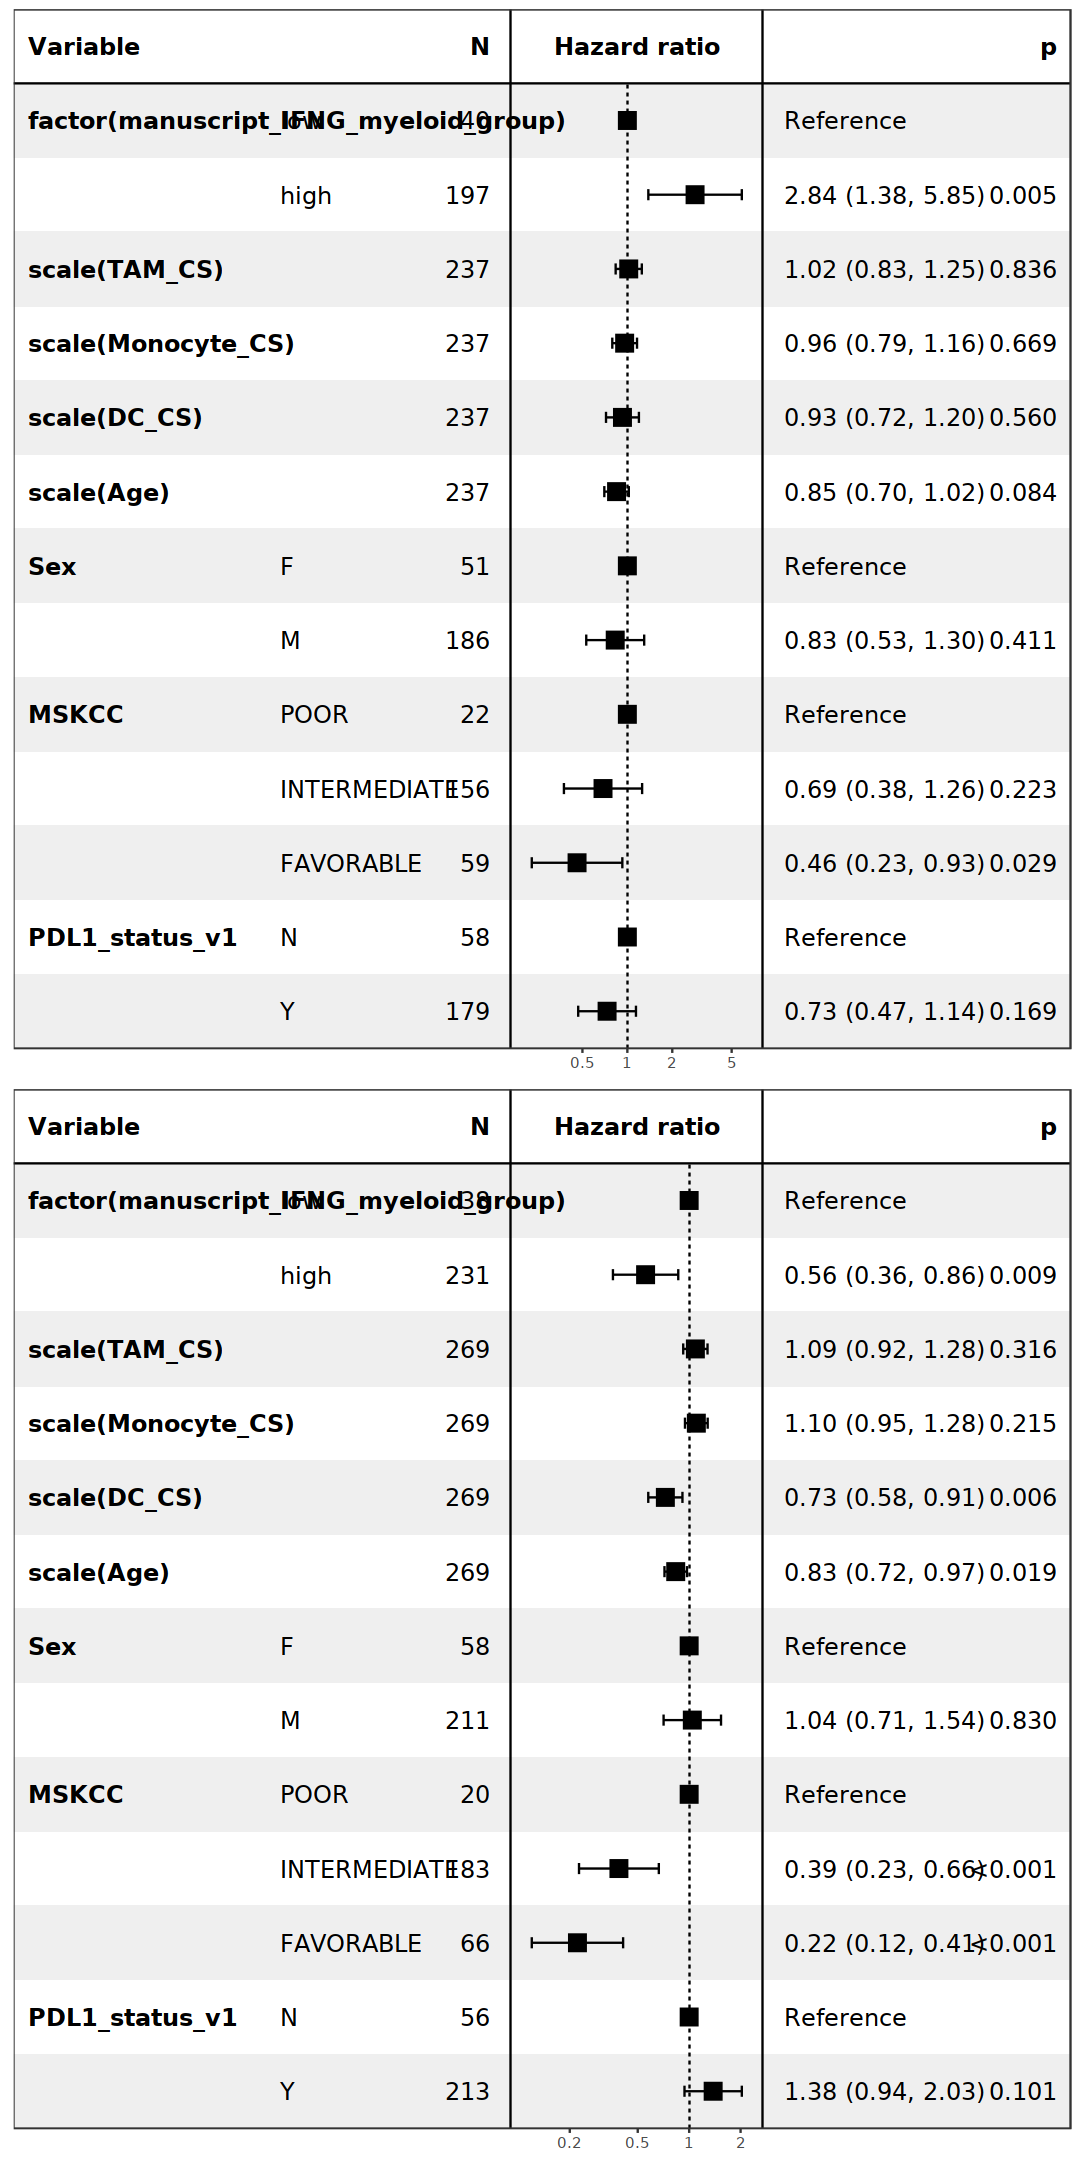

In [52]:
options(repr.plot.width=9, repr.plot.height=18)

ggarrange(jav101_icb_plot, jav101_tki_plot,ncol = 1)

ggsave("../../Supp_Figures_Final/Figure_S6/FigureS6H_J_Cox_CD8High_JAV101_ICB_TKI_Scaled.pdf",width = 9, height = 18)

### Supp Figure 6K-N. Overfitting analysis. Cox models for PFS in IO+VEGF arm of IMM151 and JAV101 (Krishna_CD8A_Tissue_resident-high samples, stratified myeloid IFNG signaling, translating cutoffs between cohorts) <a name="5"></a>

### Set panels for forest_model plots

In [53]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.23, item = "forest", hjust = 0.5, heading = "Hazard ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### Determining optimal myeloid IFNg signaling score cutoffs (scaled signature score and percentile) for Krishna CD8 predictive-high samples in IMM151

In [54]:
clin_imm151_full = readRDS("../../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

df = data.frame(table(colnames(clin_imm151_full)))
subset(df, Freq > 1)

clin_imm151_full = subset(clin_imm151_full, select = -c(IFIT3) )

Var1  Freq
8604 IFIT3 2

In [55]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
263 117 

cutpoint  statistic
Krishna_CD8A_Tissue_resident -4.336211 3.127211

$Krishna_CD8A_Tissue_resident


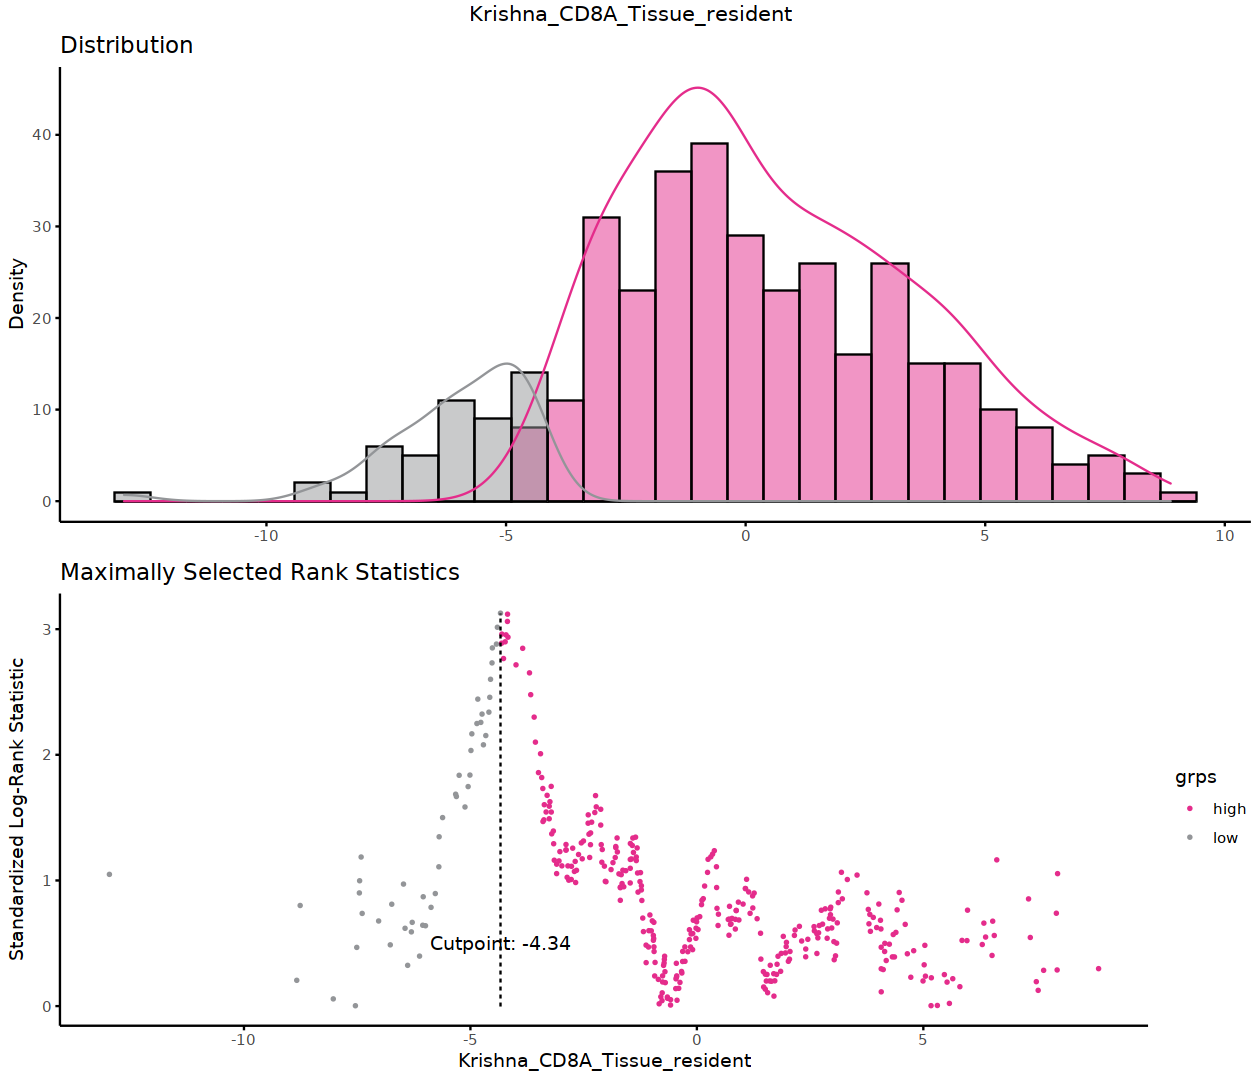

In [56]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_cd8 <- surv_cutpoint(atezo_bev, time = "PFS_MONTHS", event = "PFS_CENSOR",minprop = 0,
   variables = c("Krishna_CD8A_Tissue_resident"))
summary(res.cut_cd8)

plot(res.cut_cd8, "Krishna_CD8A_Tissue_resident", palette = c("#e42c8b","#939598"))

In [57]:
atezo_bev_topcd8 = subset(atezo_bev, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(atezo_bev_topcd8)

[1]   331 25639

In [58]:
atezo_bev_topcd8$manuscript_IFNG_myeloid_scale = as.numeric(scale(atezo_bev_topcd8$manuscript_IFNG_myeloid))
head(atezo_bev_topcd8$manuscript_IFNG_myeloid_scale)

[1]  0.8431385 -0.1218769 -1.2541250 -0.9828558  0.5529765 -0.5126496

cutpoint   statistic
manuscript_IFNG_myeloid_scale -0.9191376 3.637437

$manuscript_IFNG_myeloid_scale


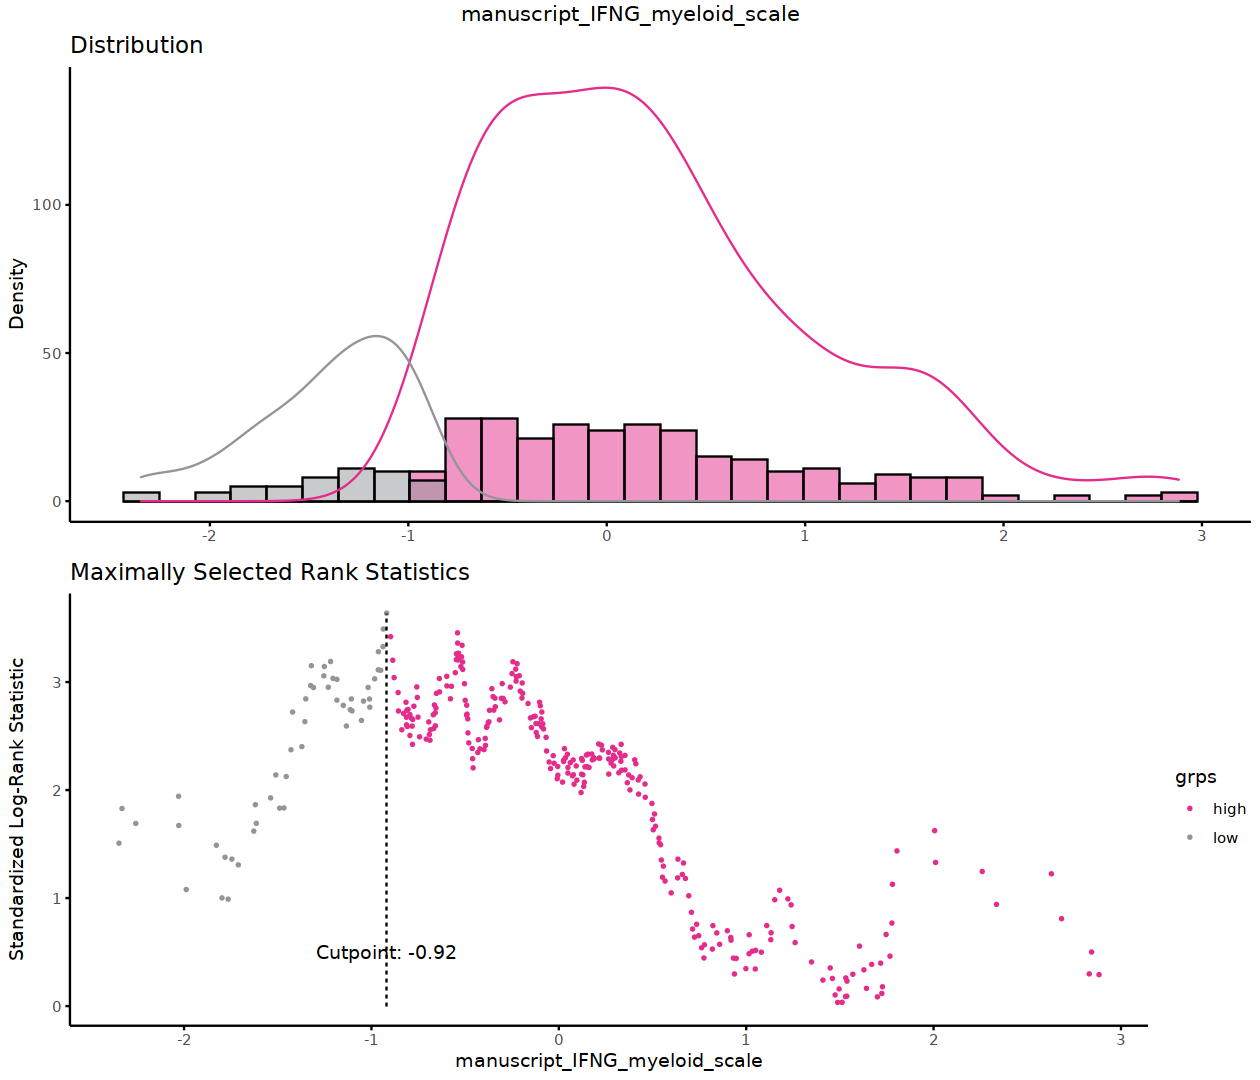

In [59]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_myeloid <- surv_cutpoint(atezo_bev_topcd8, time = "PFS_MONTHS", event = "PFS_CENSOR",minprop = 0,
   variables = c("manuscript_IFNG_myeloid_scale"))
summary(res.cut_myeloid)

plot(res.cut_myeloid, "manuscript_IFNG_myeloid_scale", palette = c("#e42c8b","#939598"))

In [60]:
res.cat <- surv_categorize(res.cut_myeloid)
head(res.cat)
dim(res.cat)
table(res.cat$manuscript_IFNG_myeloid_scale)

PFS_MONTHS PFS_CENSOR manuscript_IFNG_myeloid_scale
EA-c98e425b64 11.43       TRUE      high                         
EA-50a17b762a  9.76       TRUE      high                         
EA-503b2e1876 11.24      FALSE      low                          
EA-9be3b7c254 23.39      FALSE      low                          
EA-cce8886053  2.07       TRUE      high                         
EA-858e45ba5f 11.17       TRUE      high

[1] 331   3


high  low 
 279   52 

In [61]:
atezo_bev_topcd8$manuscript_IFNG_myeloid_group = res.cat$manuscript_IFNG_myeloid_scale
atezo_bev_topcd8$manuscript_IFNG_myeloid_group = factor(atezo_bev_topcd8$manuscript_IFNG_myeloid_group, levels = c("low","high"))
table(atezo_bev_topcd8$manuscript_IFNG_myeloid_group)


 low high 
  52  279 

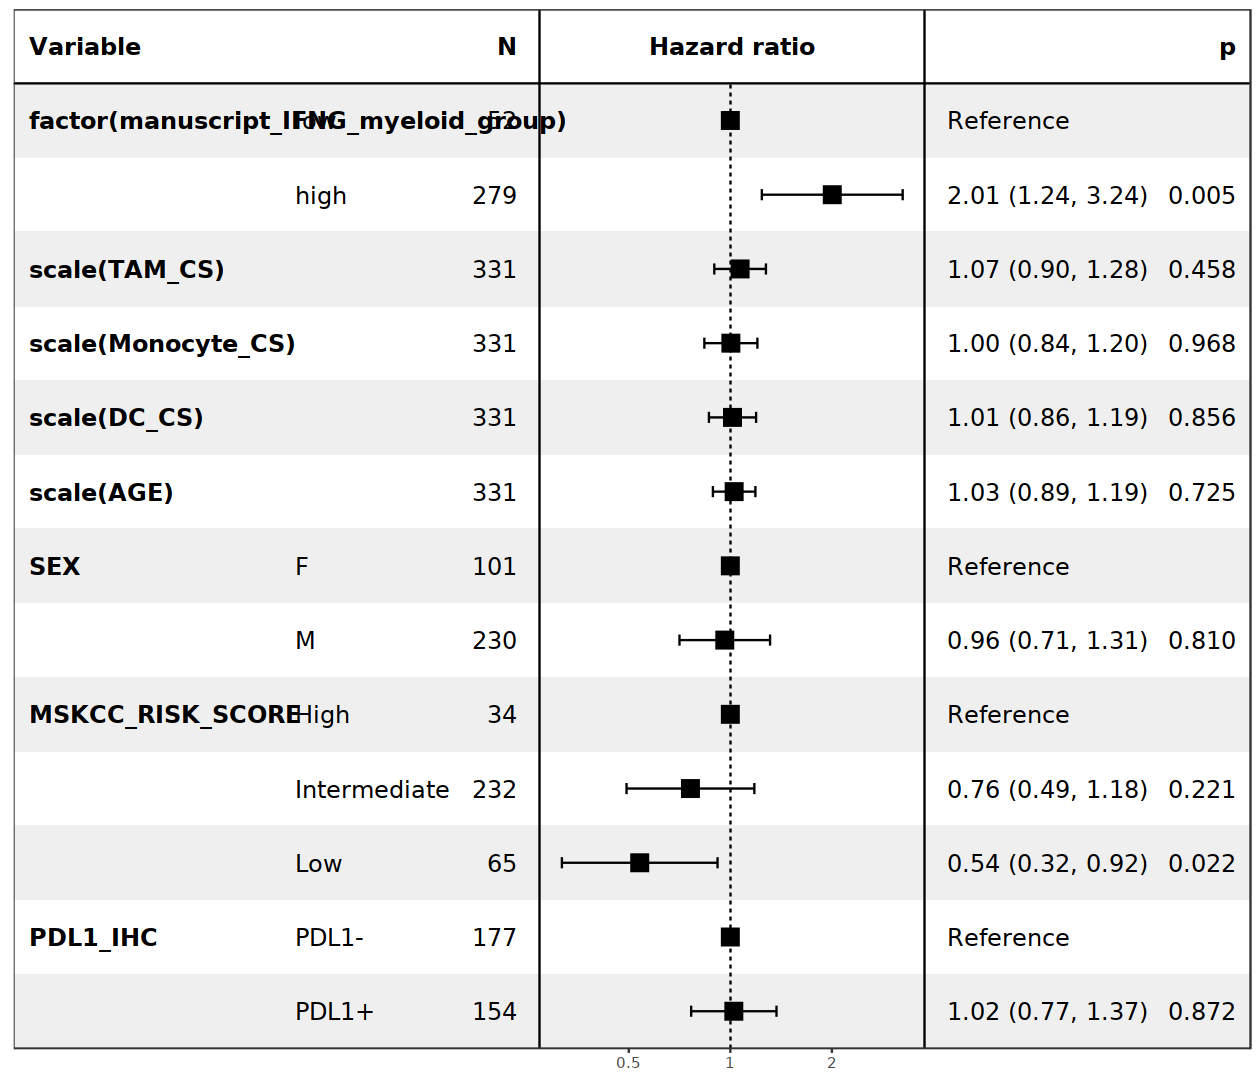

In [62]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev_topcd8)
forest_model(res.cox, panels,recalculate_width = F)

In [63]:
min(subset(atezo_bev_topcd8, manuscript_IFNG_myeloid_group == "high")$manuscript_IFNG_myeloid_scale)
max(subset(atezo_bev_topcd8, manuscript_IFNG_myeloid_group == "high")$manuscript_IFNG_myeloid_scale)

[1] -0.8979047

[1] 3.403112

In [64]:
min(subset(atezo_bev_topcd8, manuscript_IFNG_myeloid_group == "low")$manuscript_IFNG_myeloid_scale)
max(subset(atezo_bev_topcd8, manuscript_IFNG_myeloid_group == "low")$manuscript_IFNG_myeloid_scale)

[1] -2.347454

[1] -0.9191376

In [65]:
im151_myeloid_cutoff = min(subset(atezo_bev_topcd8, manuscript_IFNG_myeloid_group == "high")$manuscript_IFNG_myeloid_scale)
im151_myeloid_cutoff

[1] -0.8979047

In [66]:
atezo_bev_topcd8$manuscript_IFNG_myeloid_100ntile = ntile(atezo_bev_topcd8$manuscript_IFNG_myeloid, n = 100)

cutpoint statistic
manuscript_IFNG_myeloid_100ntile 13       3.637437

$manuscript_IFNG_myeloid_100ntile


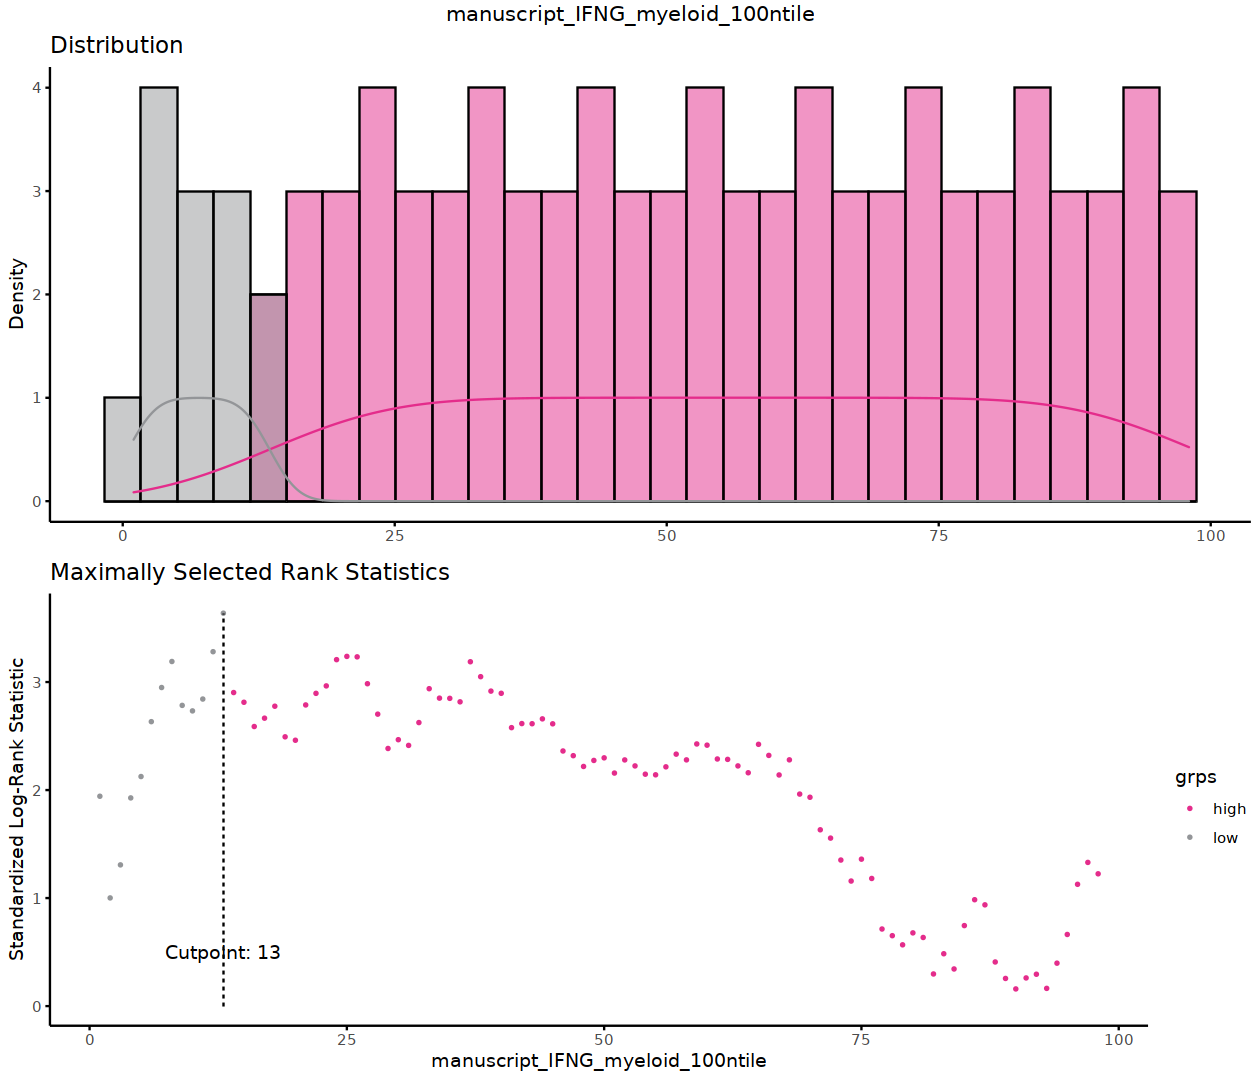

In [67]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_myeloid <- surv_cutpoint(atezo_bev_topcd8, time = "PFS_MONTHS", event = "PFS_CENSOR",minprop = 0,
   variables = c("manuscript_IFNG_myeloid_100ntile"))
summary(res.cut_myeloid)

plot(res.cut_myeloid, "manuscript_IFNG_myeloid_100ntile", palette = c("#e42c8b","#939598"))

In [68]:
res.cat <- surv_categorize(res.cut_myeloid)
head(res.cat)
dim(res.cat)
table(res.cat$manuscript_IFNG_myeloid_100ntile)

PFS_MONTHS PFS_CENSOR manuscript_IFNG_myeloid_100ntile
EA-c98e425b64 11.43       TRUE      high                            
EA-50a17b762a  9.76       TRUE      high                            
EA-503b2e1876 11.24      FALSE      low                             
EA-9be3b7c254 23.39      FALSE      low                             
EA-cce8886053  2.07       TRUE      high                            
EA-858e45ba5f 11.17       TRUE      high

[1] 331   3


high  low 
 279   52 

In [69]:
atezo_bev_topcd8$manuscript_IFNG_myeloid_group_100ntile = res.cat$manuscript_IFNG_myeloid_100ntile
atezo_bev_topcd8$manuscript_IFNG_myeloid_group_100ntile = factor(atezo_bev_topcd8$manuscript_IFNG_myeloid_group_100ntile, levels = c("low","high"))
table(atezo_bev_topcd8$manuscript_IFNG_myeloid_group_100ntile)


 low high 
  52  279 

In [70]:
min(subset(atezo_bev_topcd8, manuscript_IFNG_myeloid_group_100ntile == "high")$manuscript_IFNG_myeloid_100ntile)
max(subset(atezo_bev_topcd8, manuscript_IFNG_myeloid_group_100ntile == "high")$manuscript_IFNG_myeloid_100ntile)

[1] 14

[1] 100

In [71]:
min(subset(atezo_bev_topcd8, manuscript_IFNG_myeloid_group_100ntile == "low")$manuscript_IFNG_myeloid_100ntile)
max(subset(atezo_bev_topcd8, manuscript_IFNG_myeloid_group_100ntile == "low")$manuscript_IFNG_myeloid_100ntile)

[1] 1

[1] 13

In [72]:
im151_myeloid_percentile_cutoff = max(subset(atezo_bev_topcd8, manuscript_IFNG_myeloid_group_100ntile == "low")$manuscript_IFNG_myeloid_100ntile)
im151_myeloid_percentile_cutoff

[1] 13

### For scaled values, cutoff for in IM151 for myeloid is >= -0.897904697873658. Percentile cutoff is > 13

### Determining optimal myeloid IFNg signaling score cutoffs (scaled signature score and percentile) for Krishna CD8 predictive-high samples in JAV101

In [73]:
clin_jav101_full = readRDS("../../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

df = data.frame(table(colnames(clin_jav101_full)))
subset(df, Freq > 1)

clin_jav101_full = subset(clin_jav101_full, select = -c(CD8A,Eosinophils,IFIT3, Neutrophils) )

Var1        Freq
14682 CD8A        2   
17979 Eosinophils 2   
21236 IFIT3       2   
27495 Neutrophils 2

In [74]:
options(repr.plot.width=10.5, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
239  96 

cutpoint  statistic
Krishna_CD8A_Tissue_resident -2.855867 3.710634

$Krishna_CD8A_Tissue_resident


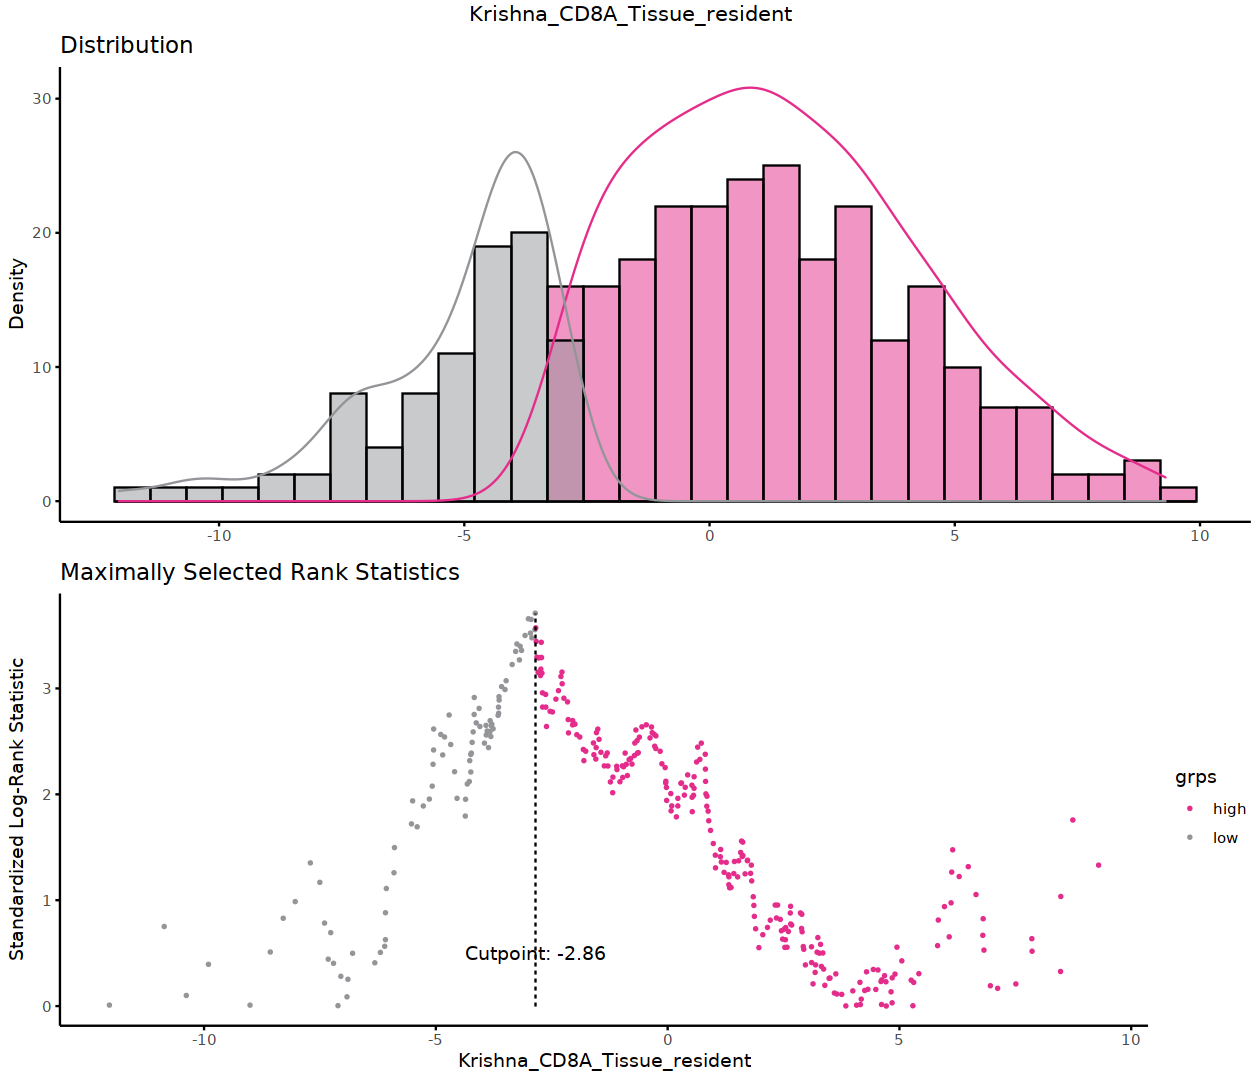

In [75]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_cd8 <- surv_cutpoint(avel_axit, time = "PFS", event = "PFS_CNSR",minprop = 0,
   variables = c("Krishna_CD8A_Tissue_resident"))
summary(res.cut_cd8)

plot(res.cut_cd8, "Krishna_CD8A_Tissue_resident", palette = c("#e42c8b","#939598"))

In [76]:
avel_axit_topcd8 = subset(avel_axit, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(avel_axit_topcd8)

[1]   245 40348

In [77]:
avel_axit_topcd8$manuscript_IFNG_myeloid_scale = as.numeric(scale(avel_axit_topcd8$manuscript_IFNG_myeloid))

cutpoint   statistic
manuscript_IFNG_myeloid_scale -0.9320083 2.767251

$manuscript_IFNG_myeloid_scale


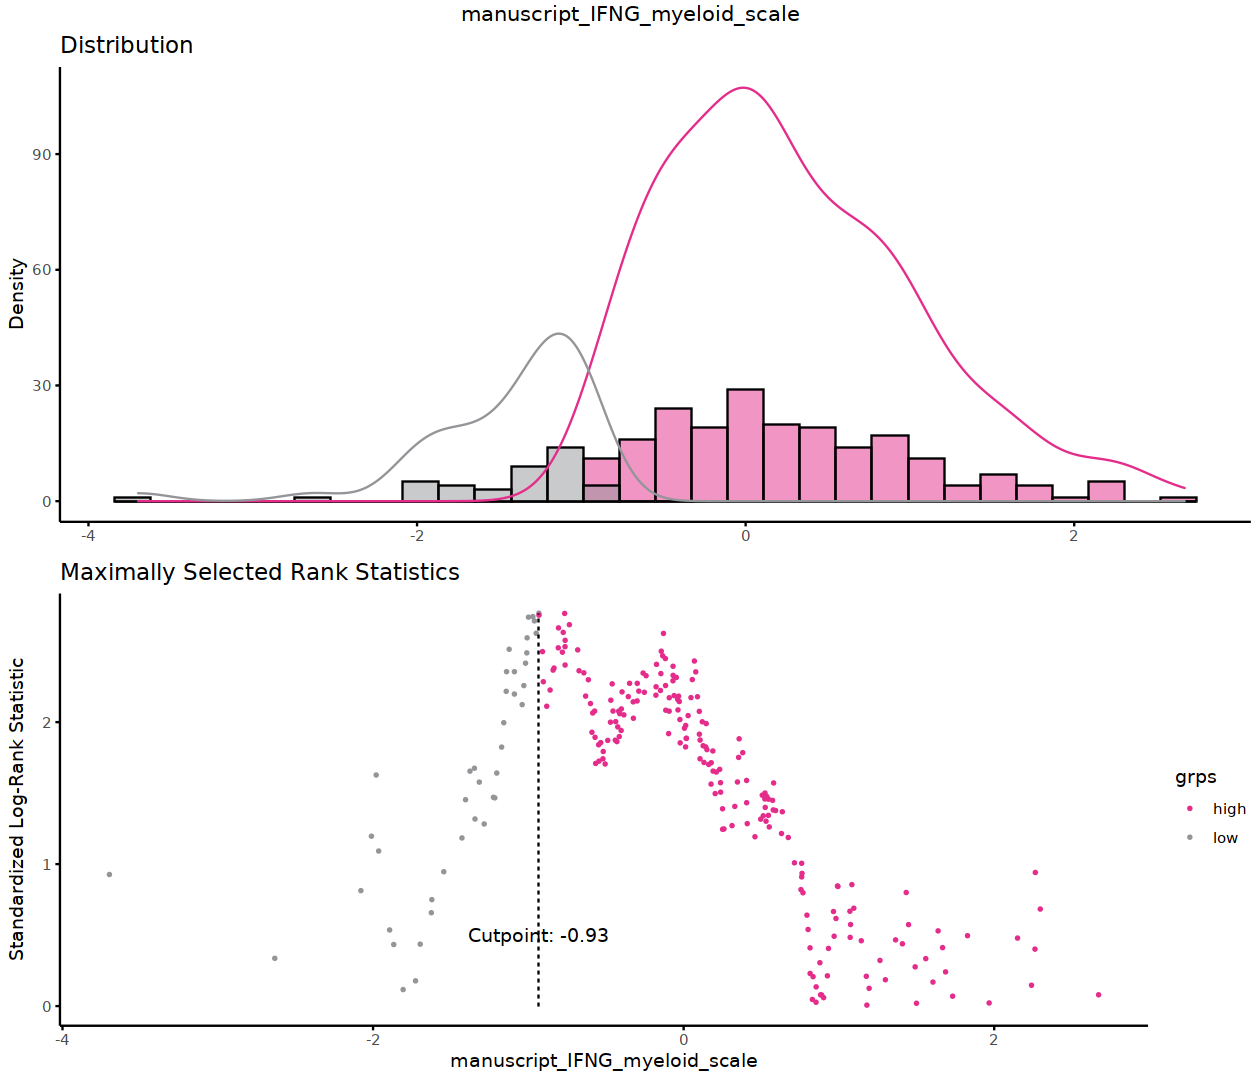

In [78]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_myeloid <- surv_cutpoint(avel_axit_topcd8, time = "PFS", event = "PFS_CNSR",minprop = 0,
   variables = c("manuscript_IFNG_myeloid_scale"))
summary(res.cut_myeloid)

plot(res.cut_myeloid, "manuscript_IFNG_myeloid_scale", palette = c("#e42c8b","#939598"))

In [79]:
res.cat <- surv_categorize(res.cut_myeloid)
head(res.cat)
dim(res.cat)
table(res.cat$manuscript_IFNG_myeloid_scale)

PFS       PFS_CNSR manuscript_IFNG_myeloid_scale
10011001_6203185783  1.379877 1        low                          
10011015_6204820848  2.891170 1        high                         
10011017_6204067222 18.135524 0        high                         
10011020_6204820845  1.412731 1        low                          
10011021_6204820844  3.318275 0        low                          
10011027_6204067225  2.891170 1        high

[1] 245   3


high  low 
 204   41 

In [80]:
avel_axit_topcd8$manuscript_IFNG_myeloid_group = res.cat$manuscript_IFNG_myeloid_scale
avel_axit_topcd8$manuscript_IFNG_myeloid_group = factor(avel_axit_topcd8$manuscript_IFNG_myeloid_group, levels = c("low","high"))
table(avel_axit_topcd8$manuscript_IFNG_myeloid_group)


 low high 
  41  204 

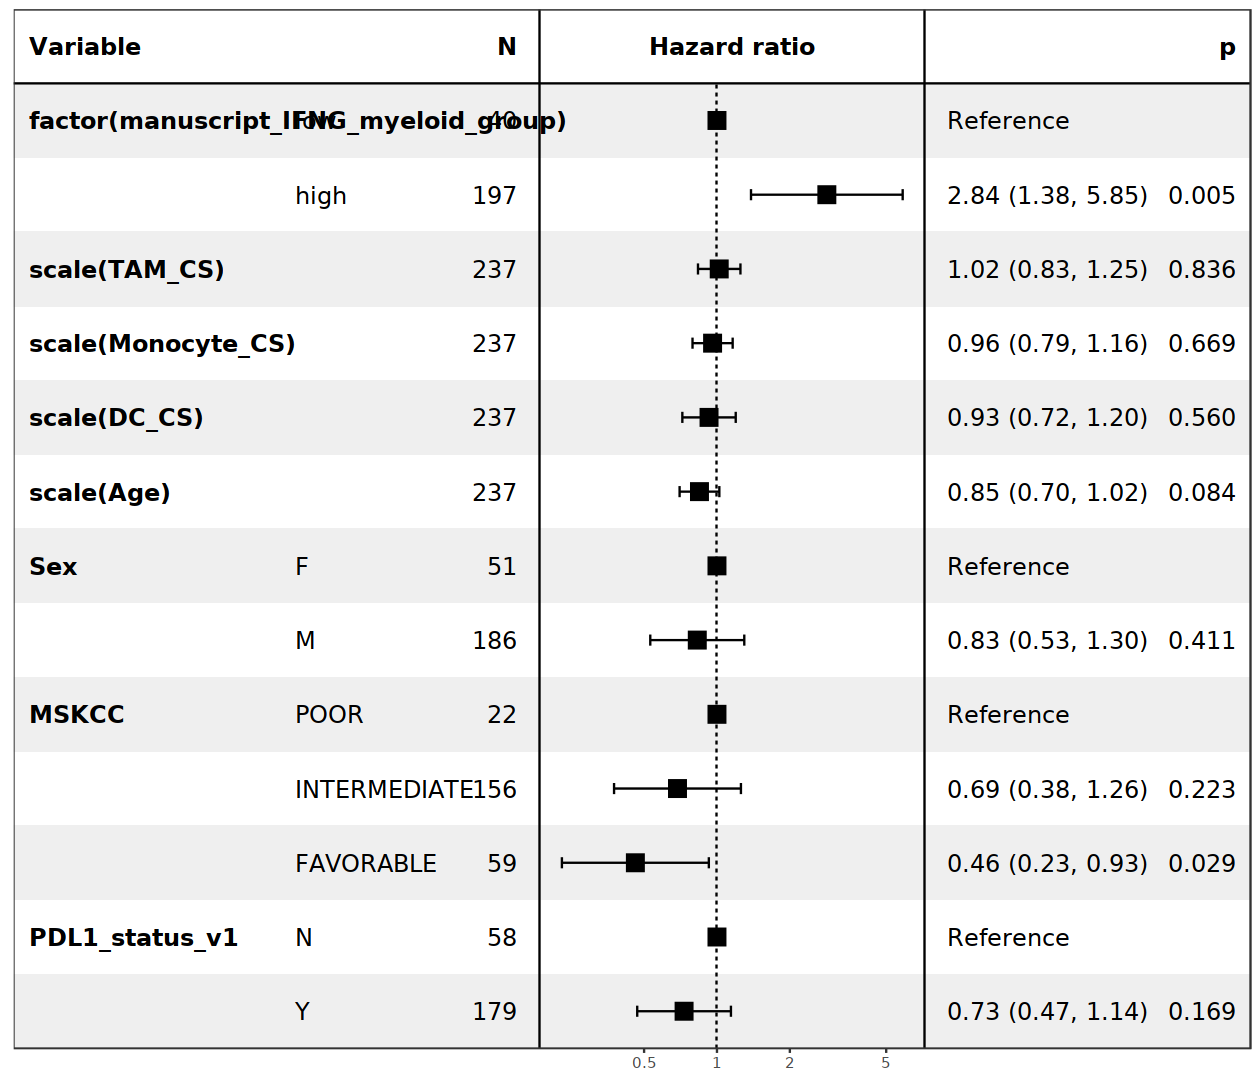

In [81]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit_topcd8)
forest_model(res.cox, panels,recalculate_width = F)

In [82]:
min(subset(avel_axit_topcd8, manuscript_IFNG_myeloid_group == "high")$manuscript_IFNG_myeloid_scale)
max(subset(avel_axit_topcd8, manuscript_IFNG_myeloid_group == "high")$manuscript_IFNG_myeloid_scale)

[1] -0.9312916

[1] 2.93077

In [83]:
min(subset(avel_axit_topcd8, manuscript_IFNG_myeloid_group == "low")$manuscript_IFNG_myeloid_scale)
max(subset(avel_axit_topcd8, manuscript_IFNG_myeloid_group == "low")$manuscript_IFNG_myeloid_scale)

[1] -3.69791

[1] -0.9320083

In [84]:
jr101_myeloid_cutoff = min(subset(avel_axit_topcd8, manuscript_IFNG_myeloid_group == "high")$manuscript_IFNG_myeloid_scale)
jr101_myeloid_cutoff

[1] -0.9312916

In [85]:
avel_axit_topcd8$manuscript_IFNG_myeloid_100ntile = ntile(avel_axit_topcd8$manuscript_IFNG_myeloid, n = 100)

cutpoint statistic
manuscript_IFNG_myeloid_100ntile 14       2.753523

$manuscript_IFNG_myeloid_100ntile


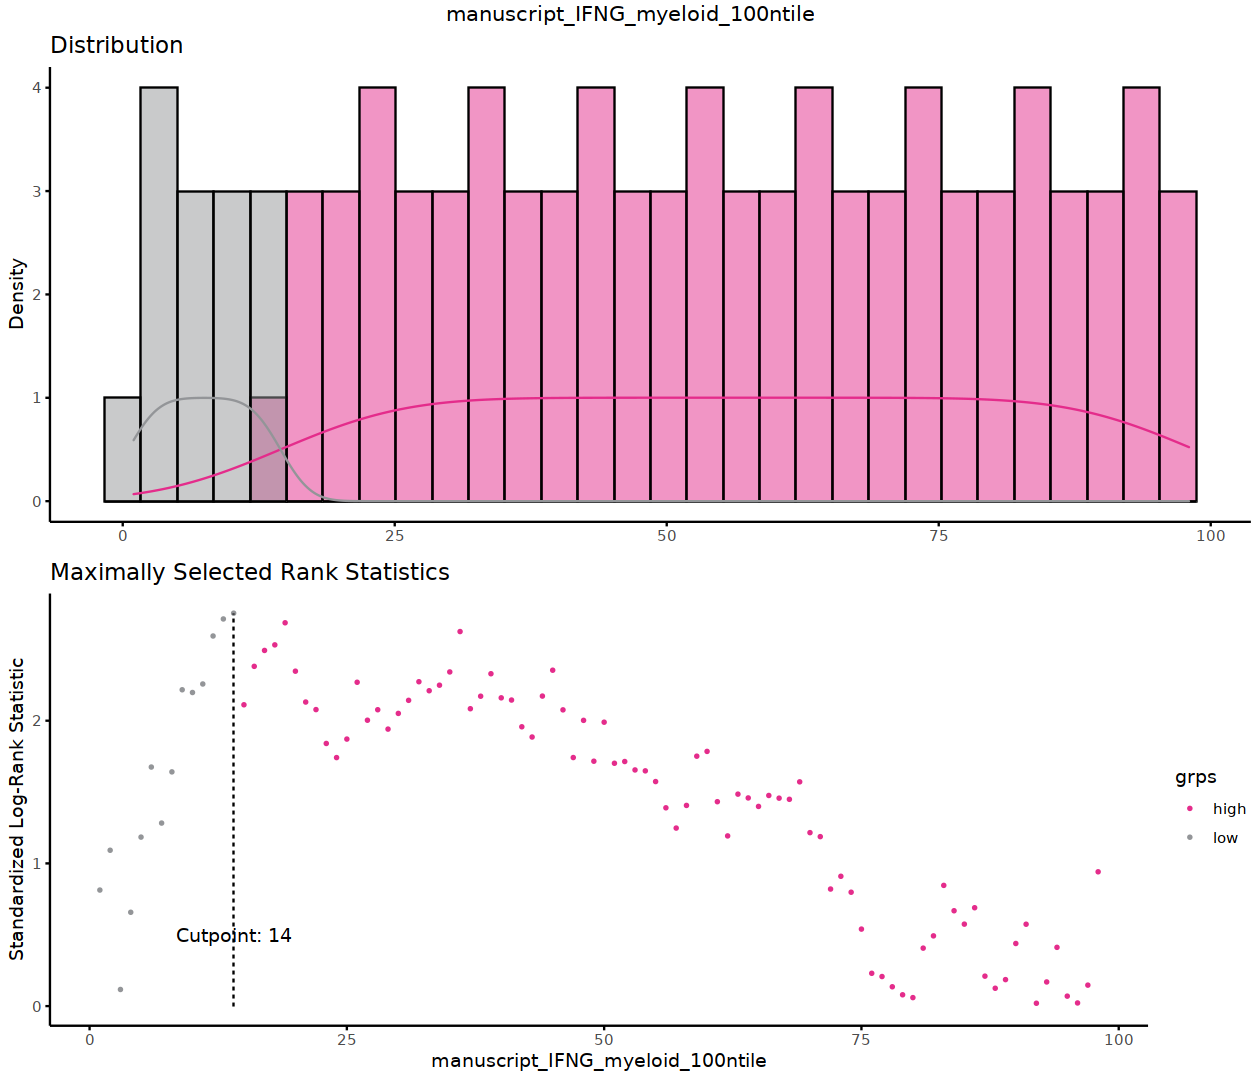

In [86]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_myeloid <- surv_cutpoint(avel_axit_topcd8, time = "PFS", event = "PFS_CNSR",minprop = 0,
   variables = c("manuscript_IFNG_myeloid_100ntile"))
summary(res.cut_myeloid)

plot(res.cut_myeloid, "manuscript_IFNG_myeloid_100ntile", palette = c("#e42c8b","#939598"))

In [87]:
res.cat <- surv_categorize(res.cut_myeloid)
head(res.cat)
dim(res.cat)
table(res.cat$manuscript_IFNG_myeloid_100ntile)

PFS       PFS_CNSR manuscript_IFNG_myeloid_100ntile
10011001_6203185783  1.379877 1        low                             
10011015_6204820848  2.891170 1        high                            
10011017_6204067222 18.135524 0        high                            
10011020_6204820845  1.412731 1        low                             
10011021_6204820844  3.318275 0        low                             
10011027_6204067225  2.891170 1        high

[1] 245   3


high  low 
 203   42 

In [88]:
avel_axit_topcd8$manuscript_IFNG_myeloid_group_100ntile = res.cat$manuscript_IFNG_myeloid_100ntile
avel_axit_topcd8$manuscript_IFNG_myeloid_group_100ntile = factor(avel_axit_topcd8$manuscript_IFNG_myeloid_group_100ntile, levels = c("low","high"))
table(avel_axit_topcd8$manuscript_IFNG_myeloid_group_100ntile)


 low high 
  42  203 

In [89]:
min(subset(avel_axit_topcd8, manuscript_IFNG_myeloid_group_100ntile == "high")$manuscript_IFNG_myeloid_100ntile)
max(subset(avel_axit_topcd8, manuscript_IFNG_myeloid_group_100ntile == "high")$manuscript_IFNG_myeloid_100ntile)

[1] 15

[1] 100

In [90]:
min(subset(avel_axit_topcd8, manuscript_IFNG_myeloid_group_100ntile == "low")$manuscript_IFNG_myeloid_100ntile)
max(subset(avel_axit_topcd8, manuscript_IFNG_myeloid_group_100ntile == "low")$manuscript_IFNG_myeloid_100ntile)

[1] 1

[1] 14

In [91]:
jr101_myeloid_cutoff_percentile = max(subset(avel_axit_topcd8, manuscript_IFNG_myeloid_group_100ntile == "low")$manuscript_IFNG_myeloid_100ntile)
jr101_myeloid_cutoff_percentile

[1] 14

### For scaled values, cutoff for in JAV101 for myeloid is >= -0.931291628148861. Percentile cutoff is > 14

### Supp Figure 6K-L. Cox models for PFS in ICB arm of IMM151 using scaled sig score and percentile cutoffs for myeloid IFNg signaling from JAV101

In [94]:
atezo_bev_topcd8 = mutate(atezo_bev_topcd8, manuscript_IFNG_myeloid_group_JR101 = ifelse(manuscript_IFNG_myeloid_scale >= jr101_myeloid_cutoff, "high","low"))
atezo_bev_topcd8$manuscript_IFNG_myeloid_group_JR101 =  factor(atezo_bev_topcd8$manuscript_IFNG_myeloid_group_JR101, levels = c("low","high"))
table(atezo_bev_topcd8$manuscript_IFNG_myeloid_group_JR101)


 low high 
  51  280 

In [95]:
atezo_bev_topcd8 = mutate(atezo_bev_topcd8, manuscript_IFNG_myeloid_group_JR101_pctile = ifelse(manuscript_IFNG_myeloid_100ntile > jr101_myeloid_cutoff_percentile, "high","low"))
atezo_bev_topcd8$manuscript_IFNG_myeloid_group_JR101_pctile =  factor(atezo_bev_topcd8$manuscript_IFNG_myeloid_group_JR101_pctile, levels = c("low","high"))
table(atezo_bev_topcd8$manuscript_IFNG_myeloid_group_JR101_pctile)


 low high 
  56  275 

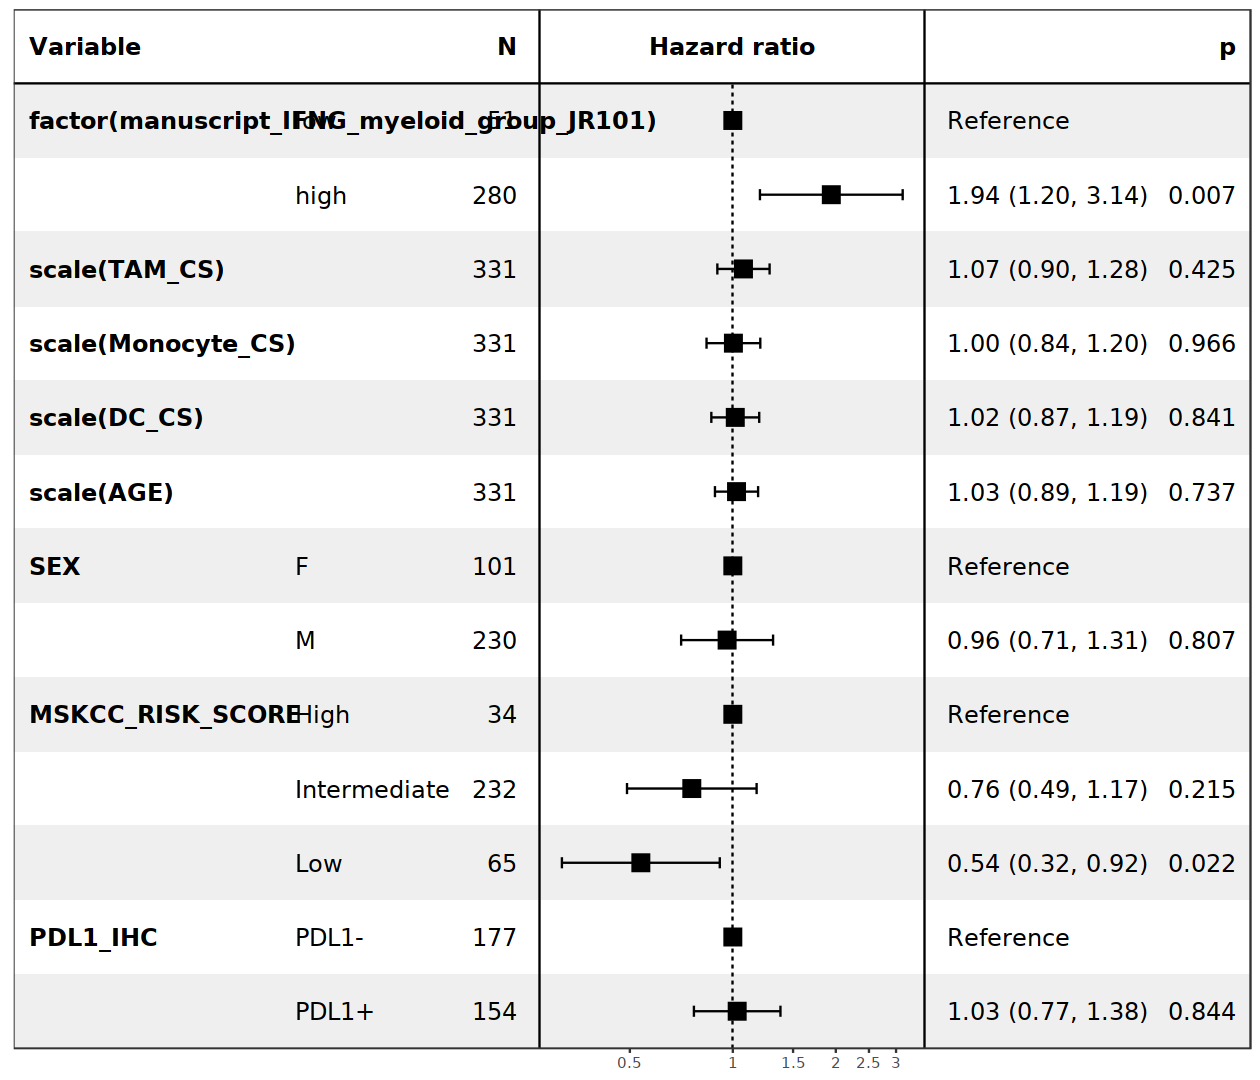

In [96]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group_JR101) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev_topcd8)
im151_jr101cut_scale = forest_model(res.cox, panels,recalculate_width = F)
im151_jr101cut_scale

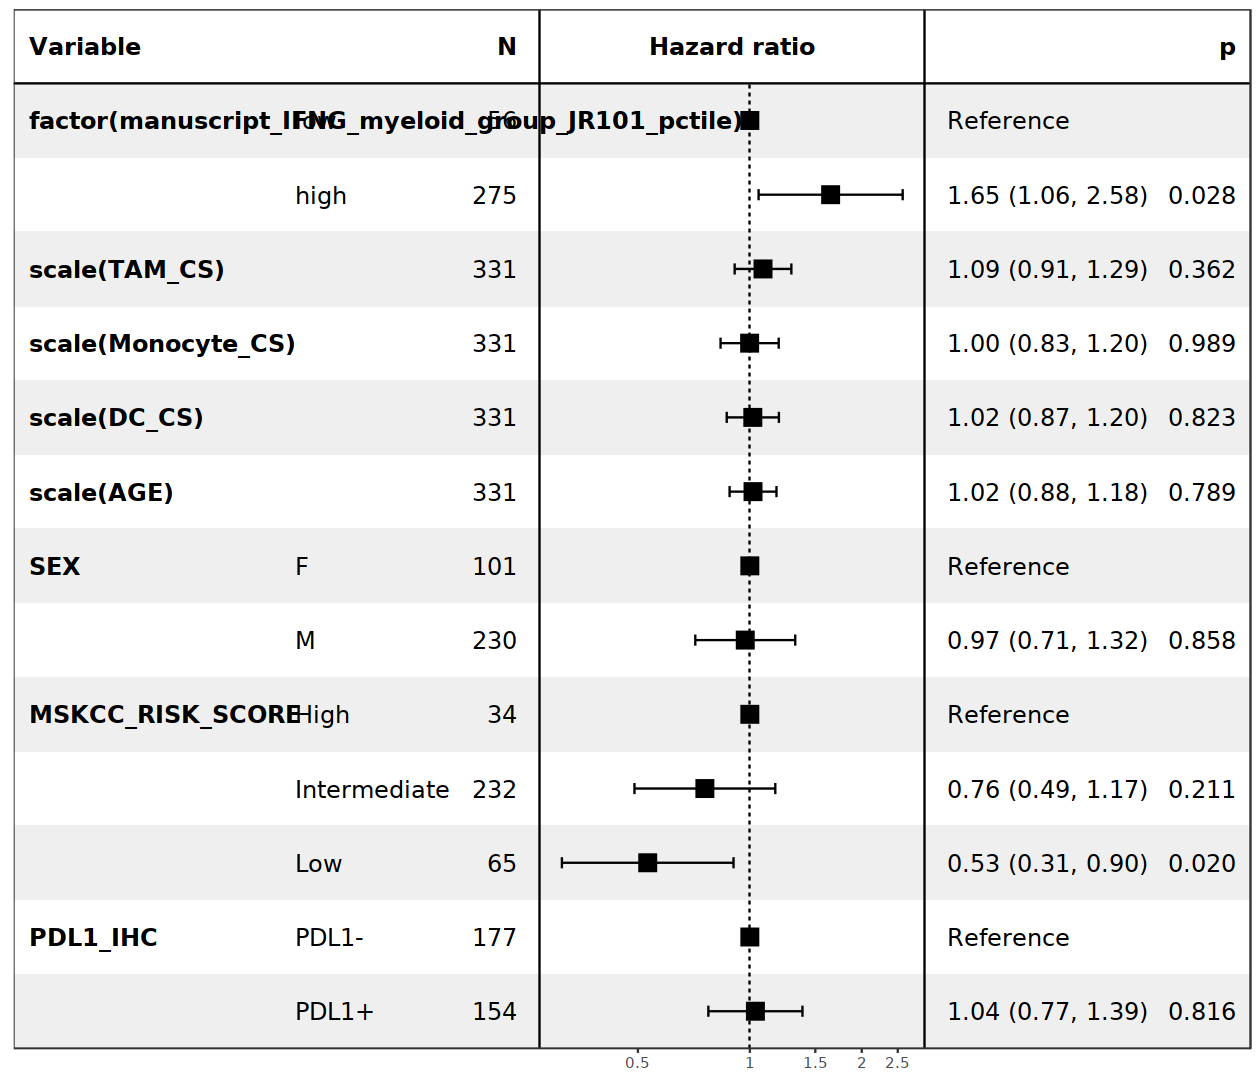

In [97]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group_JR101_pctile) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev_topcd8)
im151_jr101cut_pctile = forest_model(res.cox, panels,recalculate_width = F)
im151_jr101cut_pctile 

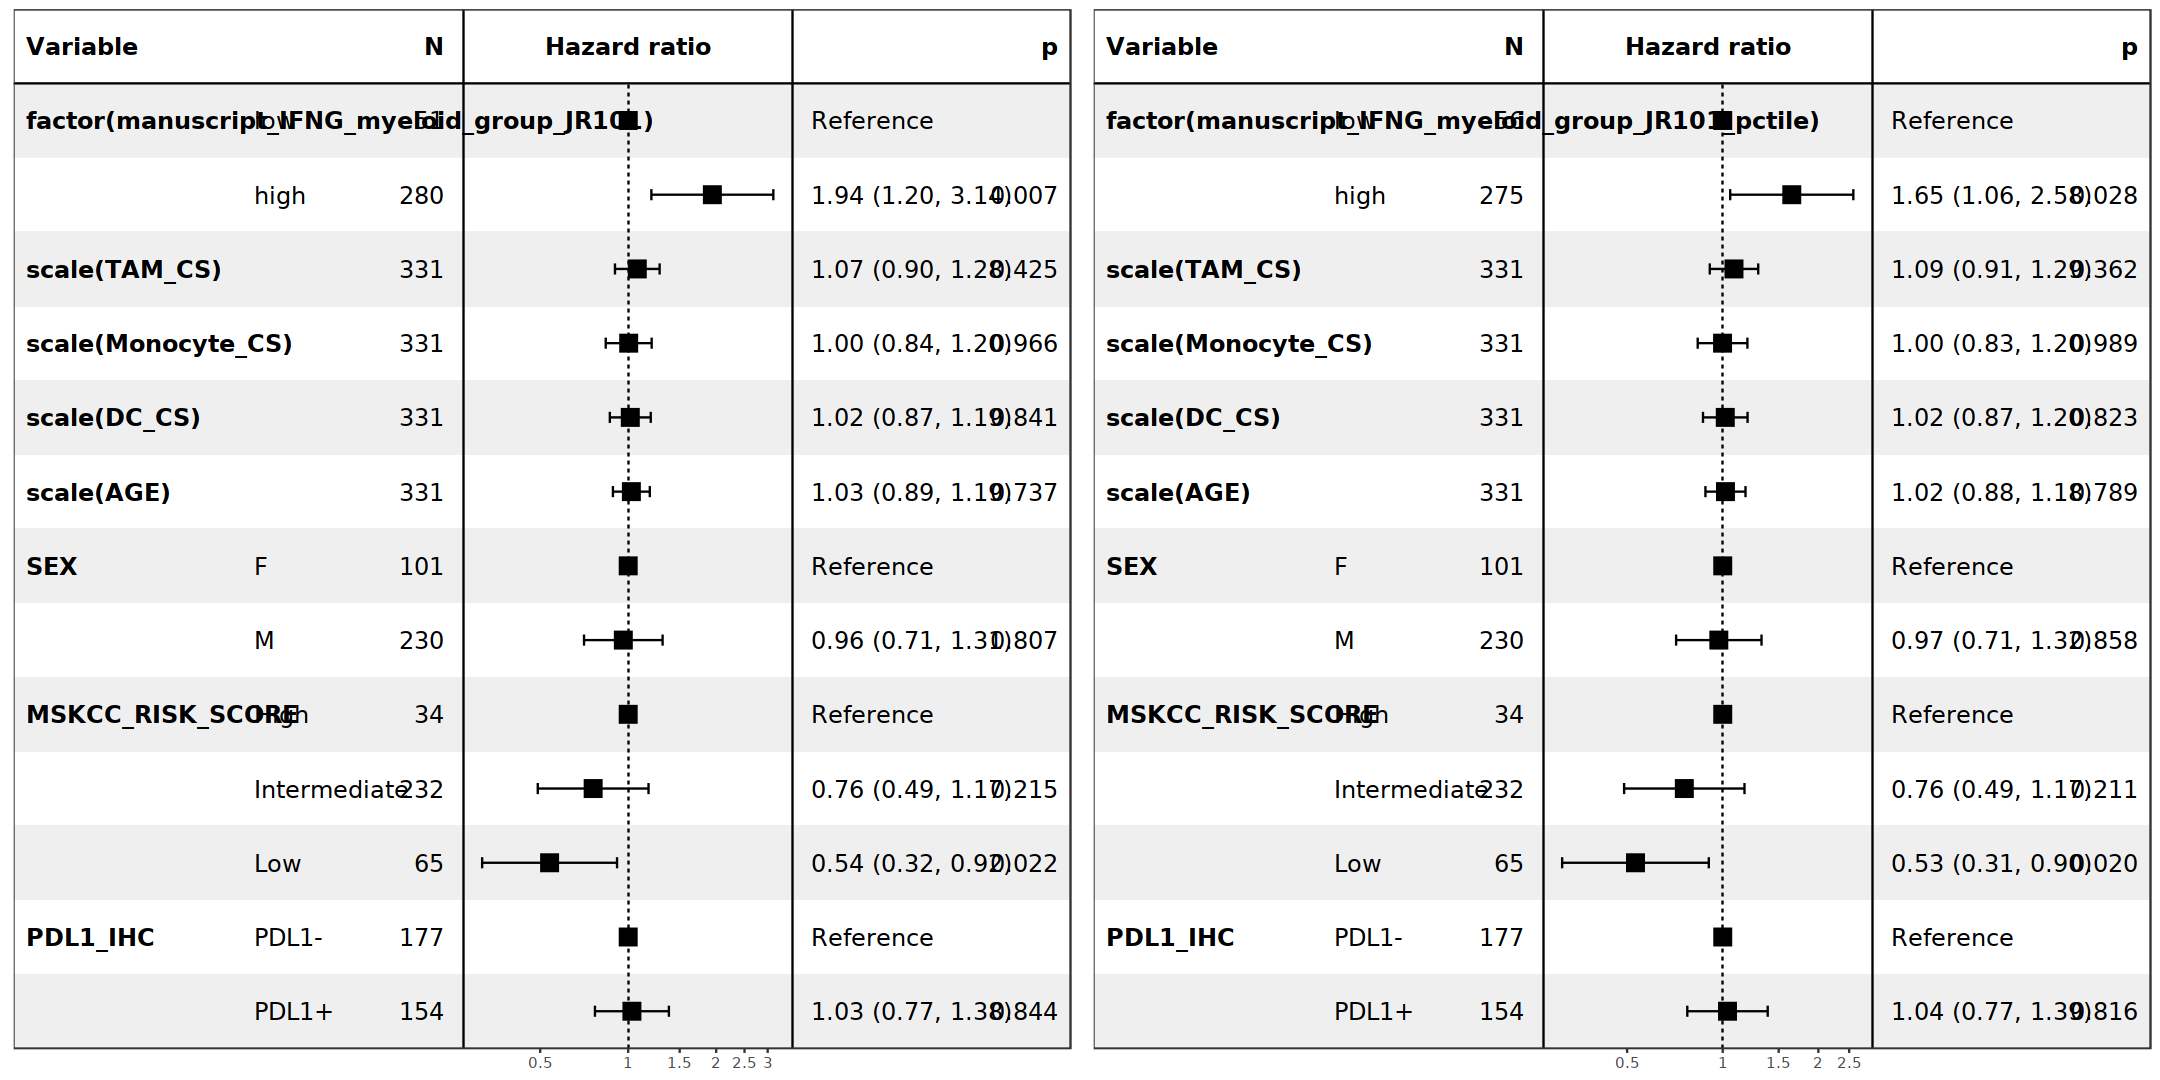

In [98]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(im151_jr101cut_scale, im151_jr101cut_pctile)

ggsave("../../Supp_Figures_Final/Figure_S6/FigureS6K_L_IMM151_w_JAV101_cutoffs.pdf",width = 18, height = 9)

### Supp Figure 6M-N. Cox models for PFS in ICB arm of JAV101 using scaled sig score and percentile cutoffs for myeloid IFNg signaling from IMM151

In [99]:
avel_axit_topcd8 = mutate(avel_axit_topcd8, manuscript_IFNG_myeloid_group_IM151 = ifelse(manuscript_IFNG_myeloid_scale >= im151_myeloid_cutoff, "high","low"))
avel_axit_topcd8$manuscript_IFNG_myeloid_group_IM151 =  factor(avel_axit_topcd8$manuscript_IFNG_myeloid_group_IM151, levels = c("low","high"))
table(avel_axit_topcd8$manuscript_IFNG_myeloid_group_IM151)


 low high 
  44  201 

In [100]:
avel_axit_topcd8 = mutate(avel_axit_topcd8, manuscript_IFNG_myeloid_group_IM151_pctile = ifelse(manuscript_IFNG_myeloid_100ntile > im151_myeloid_percentile_cutoff, "high","low"))
avel_axit_topcd8$manuscript_IFNG_myeloid_group_IM151_pctile =  factor(avel_axit_topcd8$manuscript_IFNG_myeloid_group_IM151_pctile, levels = c("low","high"))
table(avel_axit_topcd8$manuscript_IFNG_myeloid_group_IM151_pctile)


 low high 
  39  206 

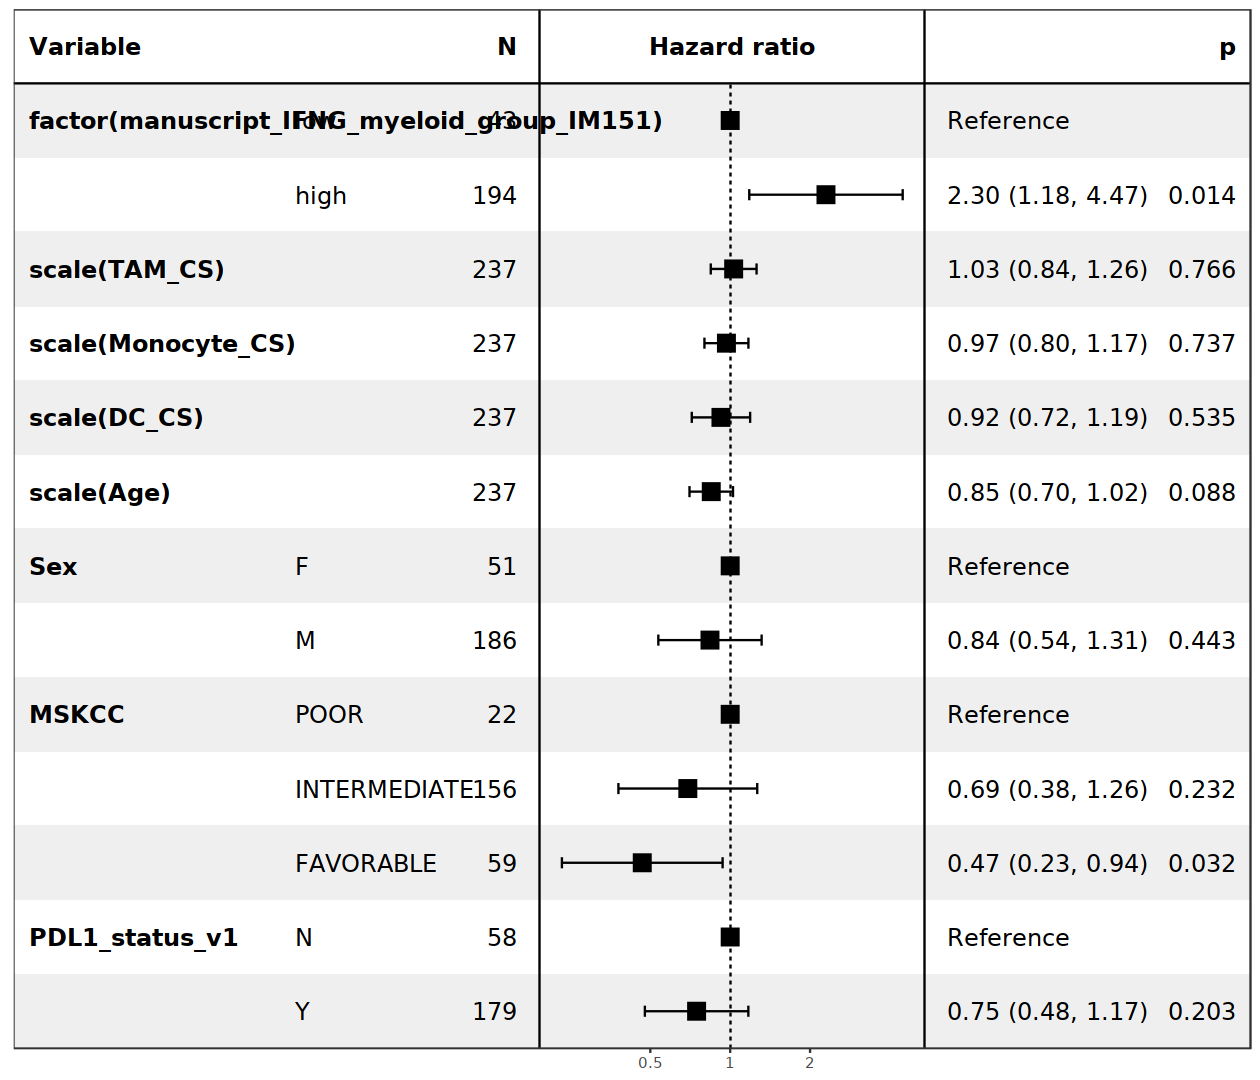

In [101]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group_IM151) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit_topcd8)
jr101_im151cut_scale = forest_model(res.cox, panels,recalculate_width = F)
jr101_im151cut_scale

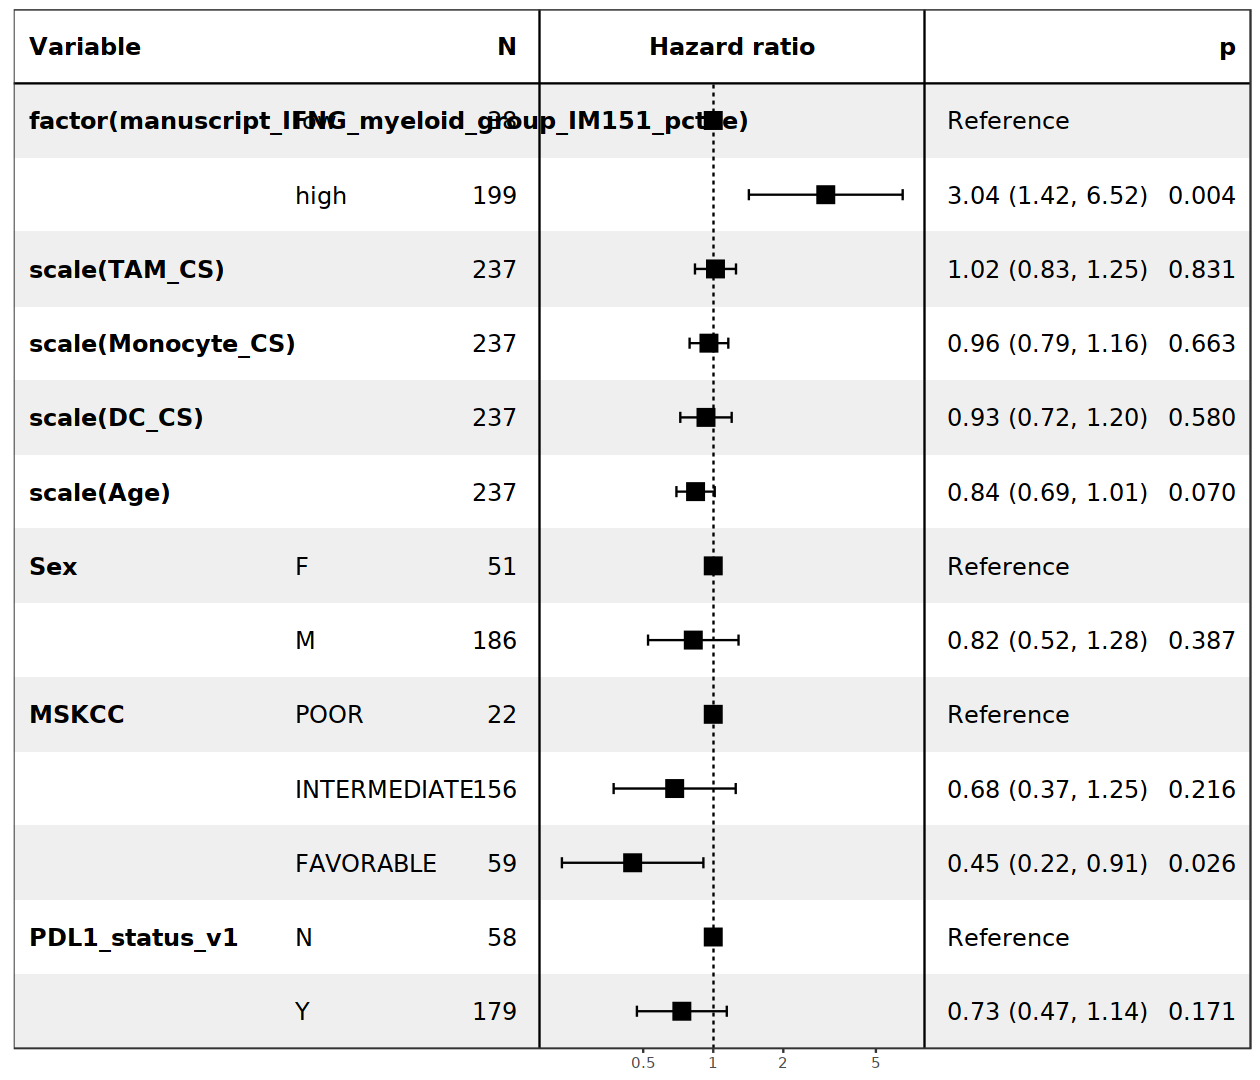

In [102]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group_IM151_pctile) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit_topcd8)
jr101_im151cut_pctile = forest_model(res.cox, panels,recalculate_width = F)
jr101_im151cut_pctile

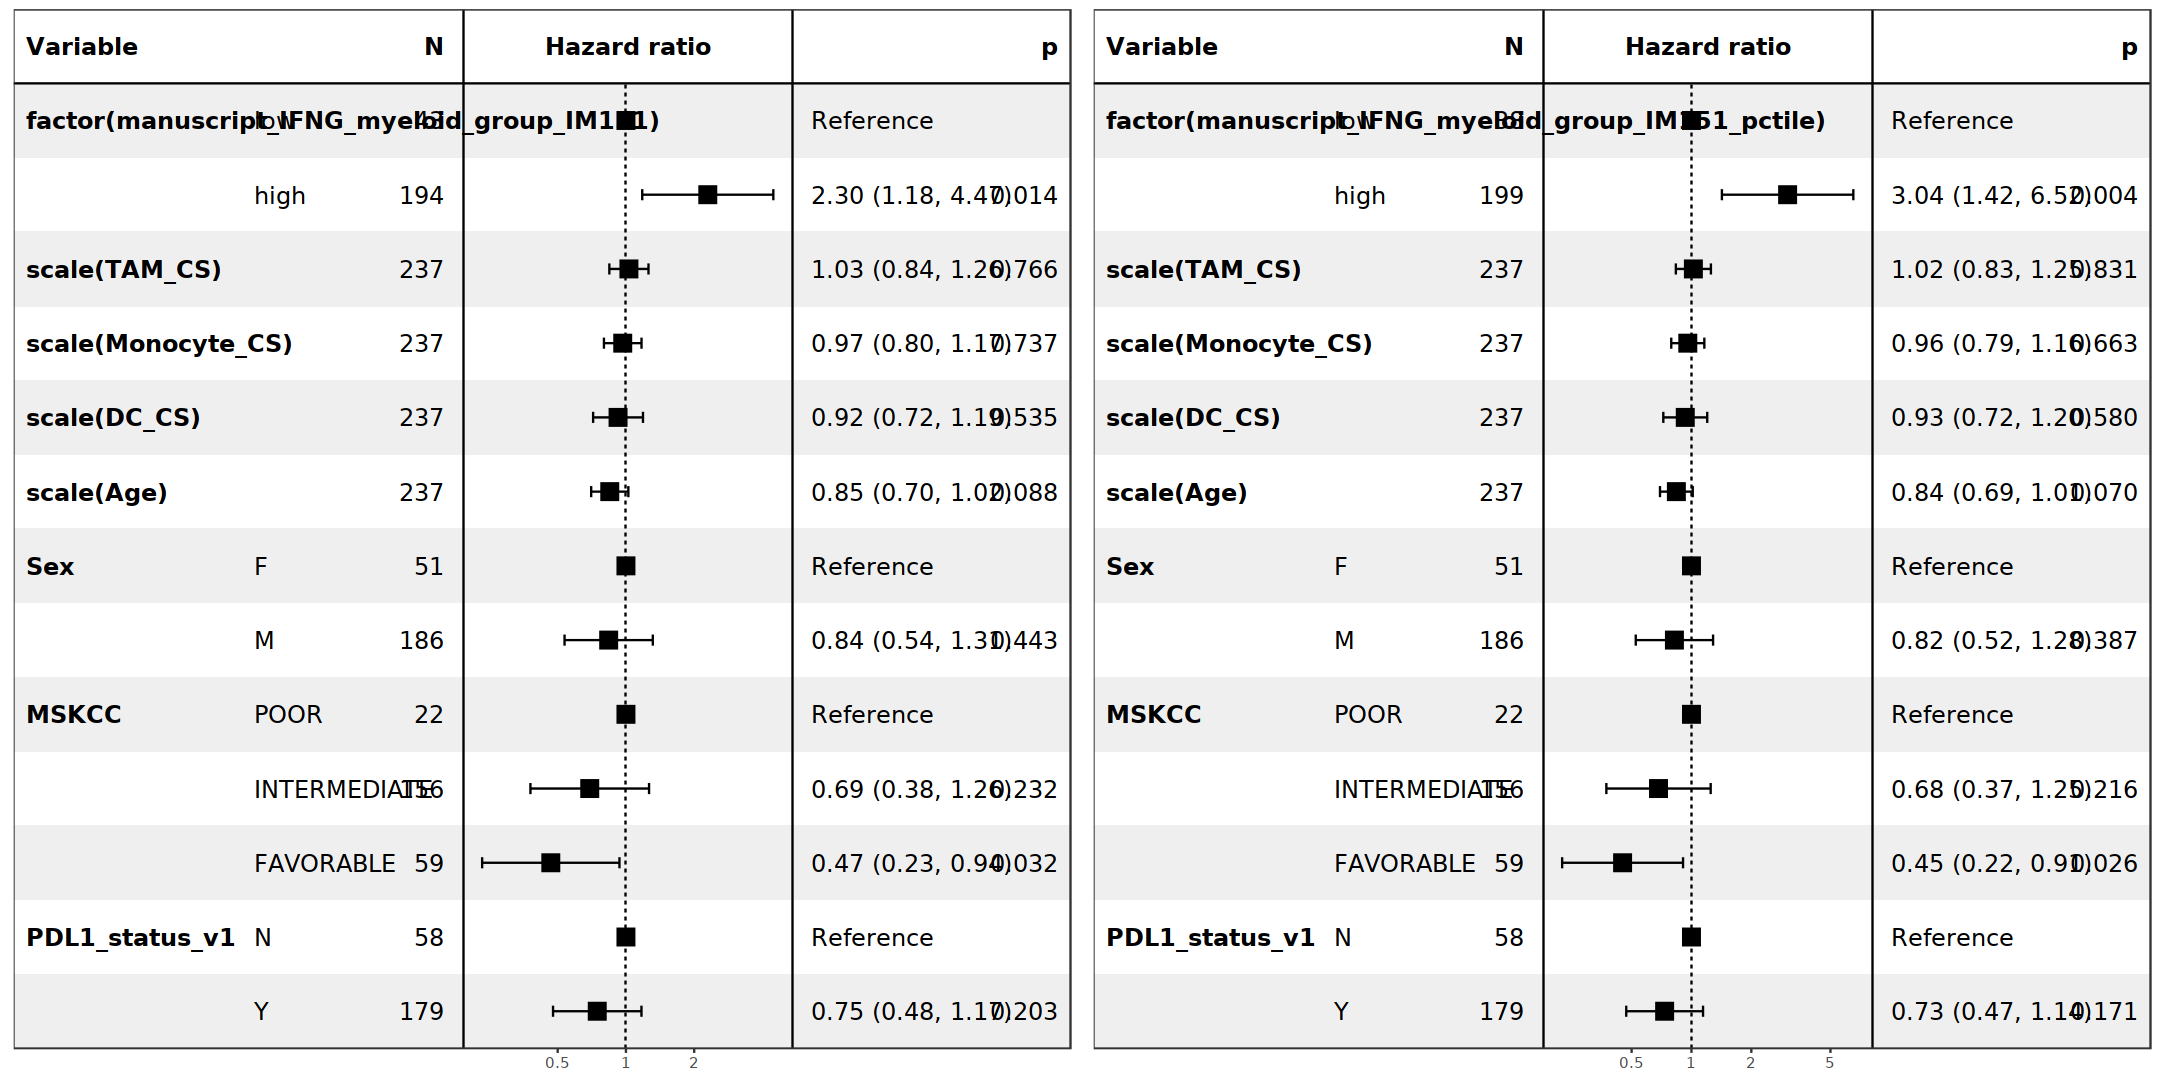

In [103]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(jr101_im151cut_scale, jr101_im151cut_pctile)

ggsave("../../Supp_Figures_Final/Figure_S6/FigureS6M_N_JAV101_w_IMM151_cutoffs.pdf",width = 18, height = 9)

In [104]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /usr/lib64/libblas.so.3.4.2
LAPACK: /broad/software/free/Linux/redhat_7_x86_64/pkgs/r_4.1.0/lib64/R/lib/libRlapack.so

locale:
[1] C

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pROC_1.17.0.1          scales_1.3.0           forestmodel_0.6.2     
 [4] forcats_0.5.2          purrr_0.3.5            readr_2.0.0           
 [7] tidyr_1.2.1            tibble_3.1.8           tidyverse_1.3.1       
[10] survminer_0.4.9.999    survival_3.2-11        yarrr_0.1.5           
[13] circlize_0.4.15        BayesFactor_0.9.12-4.2 coda_0.19-4           
[16] jpeg_0.1-9             broom_1.0.1            magrittr_2.0.3        
[19] pheatmap_1.0.12        ggridges_0.5.4         hrbrthemes_0.8.0      
[22] viridis_0.6.1          viridisLite_0.4.2    